## Questions

1. Most/least successful teams
1. Most common ground
1. highest ground averages
1. highest success at grounds
1. toss, bat, win investigation
1. best at chasing
1. best at batting 1st
1. win by biggest/smallest margin
1. scoring average trends per yer
1. win % per year
1. most success in england?
1. most common choice given won toss

Univariate
bivariate
Multivariate

## Imports & Preparation 
Lets start by reading in our cleaned dataframes, importing all the modules we'll need. We'll also need to convert the data types of some variables to categorical and datetime as this information is lost when reading .csv files with pandas.<br><br>
I like to use the standard blue in the seaborn colour palette as default colour, so I will also set up a variable to point to that.
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

df_match = pd.read_csv('../Data/interim/ODI_match_clean.csv')
df_totals = pd.read_csv('../Data/interim/ODI_totals_clean.csv')

colour = sb.color_palette()[0]

In [2]:
df_match.head()

,match_id,start_date,team1,team2,ground,result
0,3315,2013-01-03,Pakistan,India,Kolkata,Pakistan
1,3316,2013-01-06,Pakistan,India,Delhi,India
2,3317,2013-01-11,Sri Lanka,Australia,Melbourne,Australia
3,3318,2013-01-11,India,England,Rajkot,England
4,3319,2013-01-13,Sri Lanka,Australia,Adelaide,Sri Lanka


In [3]:
df_match.start_date = pd.to_datetime(df_match.start_date)
cat_cols = ['team1', 'team2', 'ground', 'result']
for col in cat_cols:
    df_match[col] = df_match[col].astype('category')
    
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 6 columns):
match_id      759 non-null int64
start_date    759 non-null datetime64[ns]
team1         759 non-null category
team2         759 non-null category
ground        759 non-null category
result        757 non-null category
dtypes: category(4), datetime64[ns](1), int64(1)
memory usage: 20.0 KB


In [4]:
df_totals.start_date = pd.to_datetime(df_totals.start_date)
cat_cols = ['country', 'opposition', 'result','bat']
for col in cat_cols:
    df_totals[col] = df_totals[col].astype('category')

df_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 13 columns):
match_id         1474 non-null int64
start_date       1474 non-null datetime64[ns]
country          1474 non-null category
toss             1474 non-null object
bat              1474 non-null category
opposition       1474 non-null category
score_total      1456 non-null float64
wickets          1474 non-null int64
overs            1474 non-null float64
rpo              1456 non-null float64
result           1470 non-null category
result_margin    1404 non-null float64
result_method    1404 non-null object
dtypes: category(4), datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 111.3+ KB


In [5]:
df_totals.head()

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,result,result_margin,result_method
0,3315,2013-01-03,Pakistan,lost,1st,India,250.0,10,48.3,5.15,won,85.0,runs
1,3315,2013-01-03,India,won,2nd,Pakistan,165.0,10,48.0,3.43,lost,85.0,runs
2,3316,2013-01-06,Pakistan,lost,2nd,India,157.0,10,48.5,3.21,lost,10.0,runs
3,3316,2013-01-06,India,won,1st,Pakistan,167.0,10,43.4,3.82,won,10.0,runs
4,3317,2013-01-11,Sri Lanka,lost,2nd,Australia,198.0,10,40.0,4.95,lost,107.0,runs


## Univariate Exploration

The main dataframe that we'll use for analysis here is `df_totals` as this contains all of the numerical data about each match played. In this section we'll look into each varaible individually, assessing the distribution of scores, overs played, runs per over (rpo), winning margins.
***
### Qualitative Variables
We'll start by investigating the qualitative variables in our data. Since each team must either win or lose the coin toss, and must bat either 1st or 2nd we will not investigate `toss` and `bat` variables in this section.

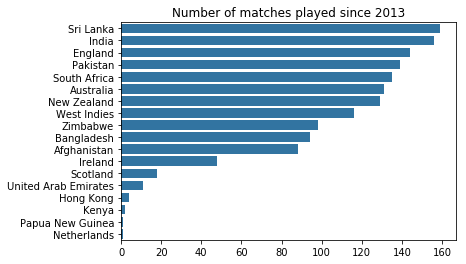

In [6]:
order = df_totals.country.value_counts().index
sb.countplot(data=df_totals, y='country', order=order, color=colour);
plt.title("Number of matches played since 2013");
plt.xlabel(None);
plt.ylabel(None);

There is a steady decline in the number of matches played per team since 2013 from Sri Lanka who have played the most. Hong Kong, Kenya, Netherlands, Papua New Guinea have all played less than 10 matches each so we might want to leave these teams out of our analysis when we start assessing averages.

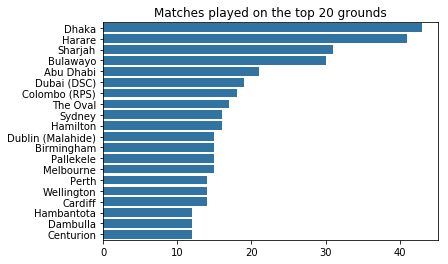

In [7]:
order = df_match.ground.value_counts().head(20).index
sb.countplot(data=df_match, y='ground', order=order, color=colour);
plt.title("Matches played on the top 20 grounds");
plt.xlabel(None);
plt.ylabel(None);

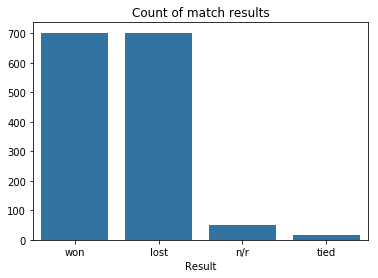

In [8]:
order = df_totals.result.value_counts().index
sb.countplot(data=df_totals, x='result', order=order, color=colour);
plt.title("Count of match results");
plt.xlabel("Result");
plt.ylabel(None);

As expected, there is an equivalent amount of matches won and lost because each match is represented here by 2 rows of data. There is a significant number of matches which do not have a result. These are likely due to weather preventing play so we might want to ignore these values later on.

In [10]:
df_totals.describe()

,match_id,score_total,wickets,overs,rpo,result_margin
count,1474.000000,1456.000000,1474.000000,1474.000000,1456.000000,1404.000000
mean,3720.238806,236.021978,7.294437,43.110516,5.386470,41.665242
std,238.129495,70.844117,2.773433,10.248984,1.169346,54.347478
min,3315.000000,8.000000,0.000000,0.000000,2.130000,1.000000
25%,3515.000000,191.000000,5.000000,40.000000,4.600000,6.000000
50%,3715.000000,240.000000,8.000000,48.000000,5.320000,9.000000
75%,3922.000000,283.000000,10.000000,50.000000,6.060000,68.000000
max,4140.000000,481.000000,10.000000,50.000000,14.160000,275.000000


### Distributions of Qantitative variables
Here we'll start by looking into the distributions of each of our quantitivative variables.
- `score_total`: technically the score in each match is discrete, since it is impossible to score a fraction of a run. Practically however, it will be easier to assess as a continuous to view the distribution.
- `overs`: this tells us how long each batting innings lasted in overs. Similarly, this is a discrete variable but for practicality we'll handle as a continuous variable. We need to be cautious because whilst the overs are often given with a decimal value, this value does not correspond to a fraction of an over but the number of balls bowled in that over. For example: 48.5 refers to 48 complete overs plus 5 balls as a pose to half an over. The maximum decimal possible is 48.5, since 48.6 == 49.0. 
- `rpo`: runs per over can also be treated as continuous.
- `wickets`: can only take integer values between 0-10 and there is discrete and we will treat as such.
- `result_margin` tells us winning margin. There are multiple ways of winning in cricket: by **X** runs if your opponents fail to reach your score, or by wickets if you reach the score that your opponets set with __X__ wickets remaining. These methods are documented in `result_method`.
- `start_date` will be usefull in looking at the number of matches played per year, month and season.
***
#### Score distribution

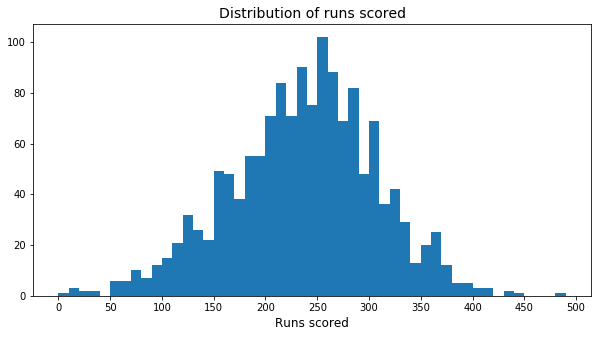

In [11]:
tick_labels = np.arange(0,501,50)
bins = np.arange(0,df_totals.score_total.max()+10, 10)

plt.figure(figsize=[10,5])
plt.hist(df_totals.score_total, bins=bins);
plt.title("Distribution of runs scored", fontsize=14);
plt.xlabel("Runs scored", fontsize=12);
plt.xticks(tick_labels,tick_labels);

The distribution is normal with marginal left skew and a maximum peak at 255 runs scored. There are a number of peaks and troughs within the distribution. 

#### Runs per over distribution

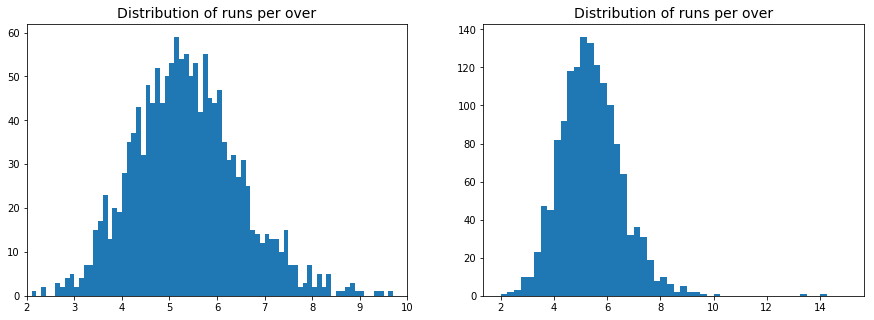

In [12]:
bins1 = np.arange(2,df_totals.rpo.max()+1,0.1)
bins2 = np.arange(2,df_totals.rpo.max()+1,0.25)

plt.figure(figsize=[15,5])
plt.subplot(1,2,1);
plt.hist(df_totals.rpo, bins=bins1);
plt.xlim(2,10)
plt.title("Distribution of runs per over", fontsize=14);

plt.subplot(1,2,2);
plt.hist(df_totals.rpo, bins=bins2);
plt.title("Distribution of runs per over", fontsize=14);


Run rate (rpo) has a general normal distribution centred around 5.3 runs per over. There is a small right skew in the data created by some outliers at 13 and 14 runs per over, which is quite exceptional. Both of these are scored by New Zealand, I expect Brendon McCullum might have had something to do with it.

#### Distribution of winning margin
To properly assess this variable we need to sepearte by the `result_method`. Remember, we are treating runs as a continuos variable and wickets as disrete so we will plot a histogram and bar char.

In [13]:
runs = df_totals.query('result_method == "runs"')
wickets = df_totals.query('result_method == "wickets"')
# runs.opposition.value_counts()

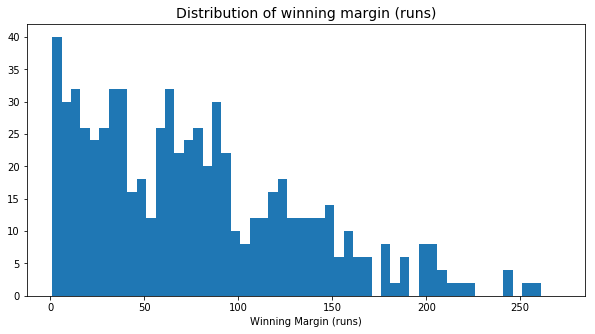

In [14]:
bins = np.arange(runs.result_margin.min(),runs.result_margin.max()+1,5)

plt.figure(figsize=[10,5])
plt.hist(runs.result_margin, bins=bins);
plt.title("Distribution of winning margin (runs)", fontsize=14);
plt.xlabel("Winning Margin (runs)");

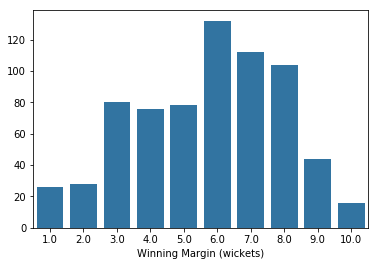

In [15]:
bins = np.arange(wickets.result_margin.min(),wickets.result_margin.max()+1,1)

sb.countplot(data=wickets, x='result_margin', color=sb.color_palette()[0]);
# plt.title("Distribution of winning margin (runs)", fontsize=14);
plt.xlabel("Winning Margin (wickets)");
plt.ylabel(None);

The distrbutions for each winning method are very different in nature. The winning margin by runs is very widely spread and heavily skewed to the right and multimodal in nature. Most matches are won by less than 100 runs. <br> <br>The winning margin by wickets has a roughly normal distribution with the most common winning margain being 6 wickets, and the least common being 1 and 10 wickets. 

#### Distribution of overs bowled

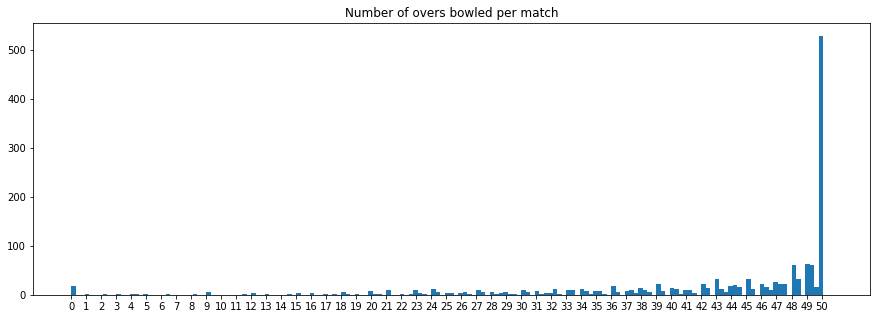

In [16]:
bins=np.arange(0,51,0.3)
ticks=np.arange(0,51,1)

plt.figure(figsize=[15,5])
plt.hist(data=df_totals, x='overs', bins=bins);
plt.title("Number of overs bowled per match");
plt.xticks(ticks,ticks);

The distribution of overs bowled is highly left skewed with the largest peak at 50 overs, occuring more than 400 times more than and other values. This can be expected, and tells us that most batting innings complete all 50 overs.

#### Distribution of wickets
This tells us how many wickets the batting team lost during their innings. 

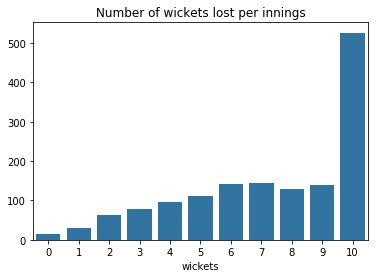

In [17]:
sb.countplot(x = df_totals.wickets, color=colour);
plt.ylabel(None);
plt.title("Number of wickets lost per innings");

Analysing the number of wickets taken per match gives a ptotentially curious result. 10 wickets are taken in 529 matches, 300 more than any other value of wickets taken. We previously saw that the majority of batting innings reach the 50 over mark, and therefore lose less than 10 wickets which contradicts what we are seeing here. <br><br>
This could be explained by the fact that a team can be bowled out during any over within the 50 overs and therefore is spread widely. Similarly, all of the innings that reach the 50 over mark have the number of wickets taken spread across 0-9 wickets taken. Lets group the data into binary groupings: "not out" and "all out", "50 overs" and "< 50 overs"

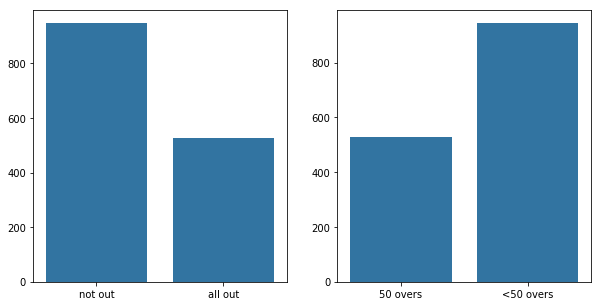

In [18]:
y = [(df_totals.wickets!=10).sum(), (df_totals.wickets==10).sum()]
x = ['not out','all out']

plt.subplots(1,2, sharey=True, figsize=[10,5])
plt.subplot(1,2,1);
sb.barplot(x = x, y=y, color=colour);

y = [(df_totals.overs!=50).sum(), (df_totals.overs==50).sum()][::-1]
x = ['<50 overs','50 overs'][::-1]

plt.subplot(1,2,2);
sb.barplot(x = x, y=y, color=colour);

The binary graphs show an interesting trend. The number of innings to reach 50 overs does not correspond to the number of innings where a team lost 10 wickets. This is because there are 451 successful run chases where a team batting second reaches the total set by the other team and therefore bringing and end to the game before 50 overs are reached. 

The chart below tells us that the coin toss was won and lost exactly 50% of the time which is, of course, to be expected because every win should have a corresponding loss, but confirms that our data entries for this variable are valid.

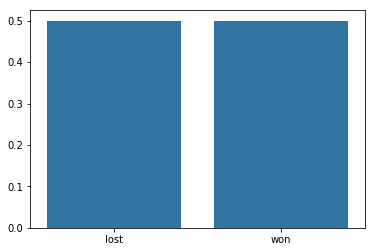

In [20]:
props=df_totals.groupby('toss').count()['match_id'].values / df_totals.shape[0]
x = df_totals.groupby('toss').count()['match_id'].index.values
sb.barplot(x=x, y=props, color=colour);

#### Matches played per year

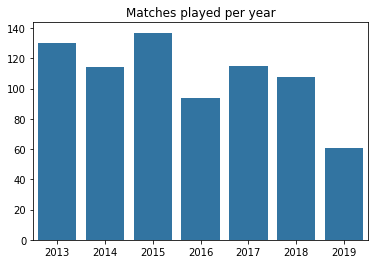

In [21]:
match_years = df_match.groupby(df_match.start_date.dt.year).count()['match_id']
sb.barplot(x=match_years.index.values, y=match_years.values, color=colour);
plt.title("Matches played per year");

2015 has the most matches played, which is the year of the previous ODI cricket world cup. 2019 has the lowest 
which also makes sense since we only have data until 2019-05-19.
***
#### Matches played per month

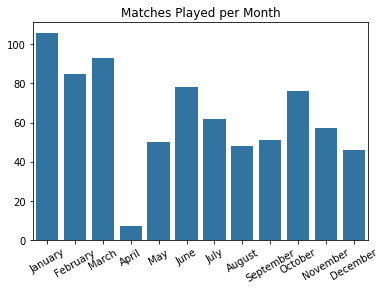

In [22]:
match_months = df_match.groupby(df_match.start_date.dt.month).count()['match_id']
sb.barplot(x=match_months.index.values, y=match_months.values, color=colour);
plt.title("Matches Played per Month");
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='30');

#### Matches played by quarter

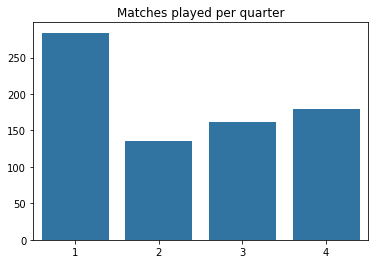

In [23]:
match_quart = df_match.groupby(df_match.start_date.dt.quarter).count()['match_id']
sb.barplot(x=match_quart.index.values, y=match_quart.values, color=sb.color_palette()[0]);
plt.title("Matches played per quarter");

Most matches are played when it is winter winter in the northern hemisphere. This is a likely result of many matches being played in India and the surrounding countries when the weather is less hot than in the heights of summer. <br><br>
There is an oddly small amount of matches that are played in April, perhaps this could mark the end of the season in Asian and Australasian countries and is before the season starts elsewhere in the world.

## Bivariate Analysis
Here we will investigate the relationships that exist between some of our variables. In order to answer most of the questions posed in the introduction we'll need to analyse the relationship between country and the other variables. We made country a categorical variable earlier in preparation for this. <br><br>
We'll start with the key question, who wins the most matches? We'll answer this based on the proportion of matches won.

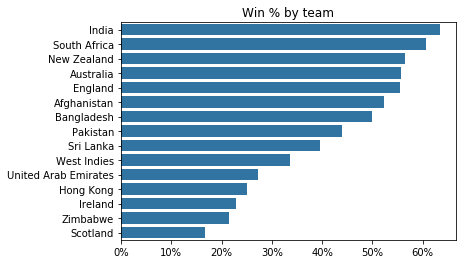

In [24]:
matches_played = df_totals.country.value_counts()
win_counts = df_totals.query('result == "won"').groupby('country').count()['match_id'].sort_values(ascending=False)
win_prop = (win_counts/matches_played).sort_values(ascending=False).head(15)

order= win_prop.index

ticks = np.arange(0,0.7,0.10)
labels = ['{:.0f}%'.format(i*100) for i in ticks]

sb.barplot(x=win_prop.values, y=win_prop.index, color=colour, order=order);
plt.xticks(ticks, labels);
plt.title("Win % by team");

# locs, labels = plt.yticks()

# for loc, label in zip(locs,labels):
#     wins = win_counts[label.get_text()]
#     prop = win_prop[label.get_text()]
#     plt.text(prop, loc, wins, va='center')

Lets look at which teams are most dangerous with the ball and take the most wickets, as well as the team that loses the most wickets.

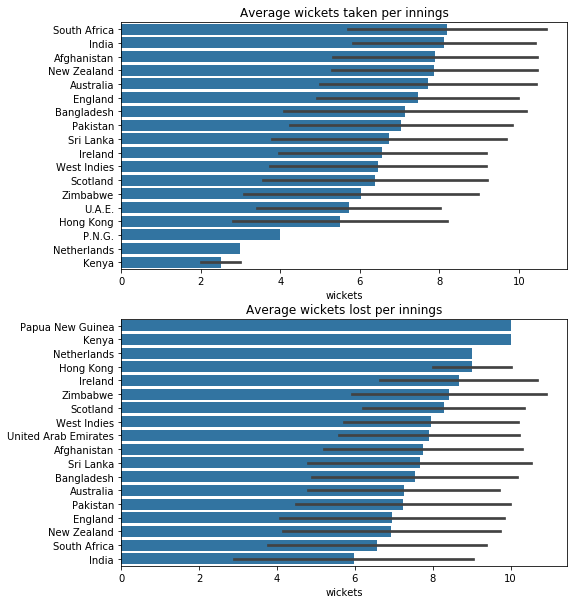

In [25]:
plt.figure(figsize=[8,10])
plt.subplot(2,1,1)
order = df_totals.groupby('opposition').mean()['wickets'].sort_values(ascending=False).index
# sb.boxplot(data = runs, x='wickets', y='opposition', order=order, color=colour);
sb.barplot(data=df_totals, x='wickets', y='opposition', color=colour, order=order, ci='sd');
plt.title("Average wickets taken per innings");
plt.ylabel(None);

plt.subplot(2,1,2)
order = df_totals.groupby('country').mean()['wickets'].sort_values(ascending=False).index
# sb.boxplot(data = runs, x='wickets', y='country', order=order, color=colour);
sb.barplot(data=df_totals, x='wickets', y='country', color=colour, order=order, ci='sd');
plt.title("Average wickets lost per innings")
plt.ylabel(None);


#### Result Margins

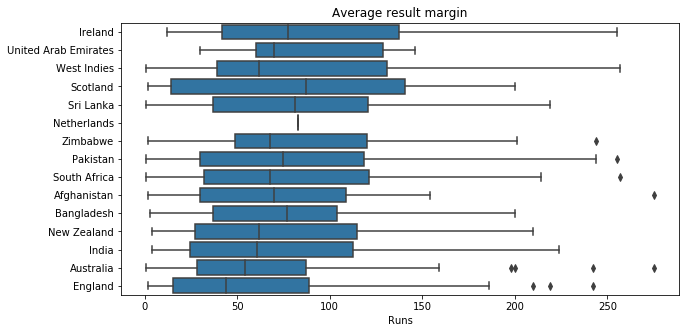

In [27]:
order = runs.groupby('country').mean()['result_margin'].sort_values(ascending=False).head(15).index
plt.figure(figsize=[10,5])
sb.boxplot(data = runs, x='result_margin', y='country', order=order, color=colour);
plt.title("Average result margin");
plt.ylabel(None);
plt.xlabel("Runs");

The result margin for each team is skewed to the right, which aligns with our observations of the overal result margin made earlier.

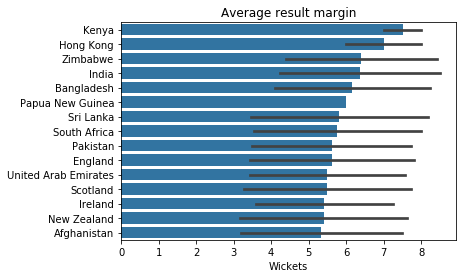

In [28]:
order = wickets.groupby('country').mean()['result_margin'].sort_values(ascending=False).head(15).index
sb.barplot(data=wickets, y='country', x='result_margin', 
           ci='sd', color=colour, order=order);
plt.title("Average result margin");
plt.ylabel(None);
plt.xlabel("Wickets");

Matches in which Ireland are involved in have the highest result margin in terms of runs, whilst matches which Kenya are involved in have the highest result margin in terms of wickets. This however does not tell us whether a team has won or lost by that margin, for that we need to include the `result` variable. We can see from the stadard deviation that the data has a large spread for most countries. More on this later.

### Scores and Run Rates 
Lets invesitage the relationships between `score_totals` and `rpo` with some other variables. Since we'll mostly be dealing with averages here it makes sense to ignore the teams that have played less than 10 matches each, keeping the rows in which they are an opponent only. `country` is categorical type, so to avoid plotting empty panels we'll temporarilly convert this back to object type.
***
#### Score vs rpo
Lets starts with the relationship between `score_totals` and `rpo`. We might expect this to be fairly linear since `rpo` is calculated using the `score_total`.

In [85]:
# Get countries that have played more than 10 matches
countries10 = df_totals.country.value_counts()[df_totals.country.value_counts() > 10].index
df_temp = df_totals[df_totals.country.isin(countries10)]
df_temp.country = df_temp.country.astype(object)
df_temp.opposition = df_temp.opposition.astype(object)

/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


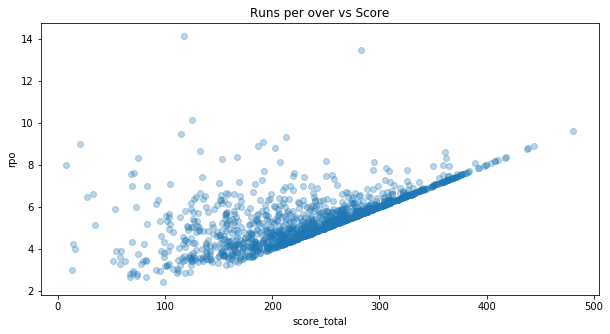

In [30]:
plt.figure(figsize=[10,5])
sb.regplot(data=df_temp, y='rpo', x='score_total', scatter_kws={'alpha':0.3}, fit_reg=False);
plt.title("Runs per over vs Score");

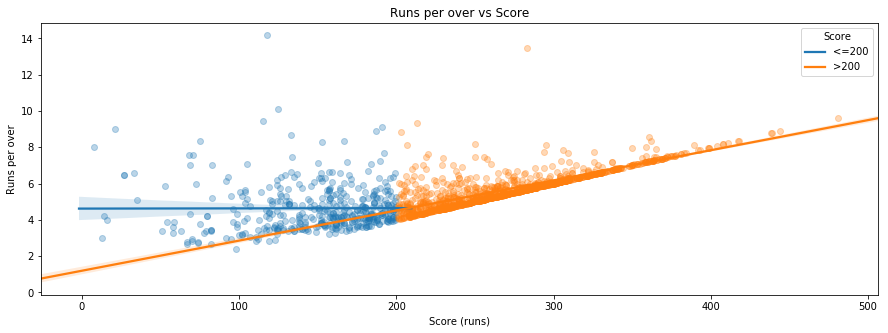

In [95]:
plt.figure(figsize=[15,5])

sb.regplot(data=df_temp[df_temp.score_total <= 200], y='rpo', x='score_total', scatter_kws={'alpha':0.3});
sb.regplot(data=df_temp[df_temp.score_total > 200], y='rpo', x='score_total', scatter_kws={'alpha':0.3});
plt.title("Runs per over vs Score");
plt.legend(title="Score",labels=['<=200', '>200']);
plt.xlabel("Score (runs)");
plt.ylabel("Runs per over");

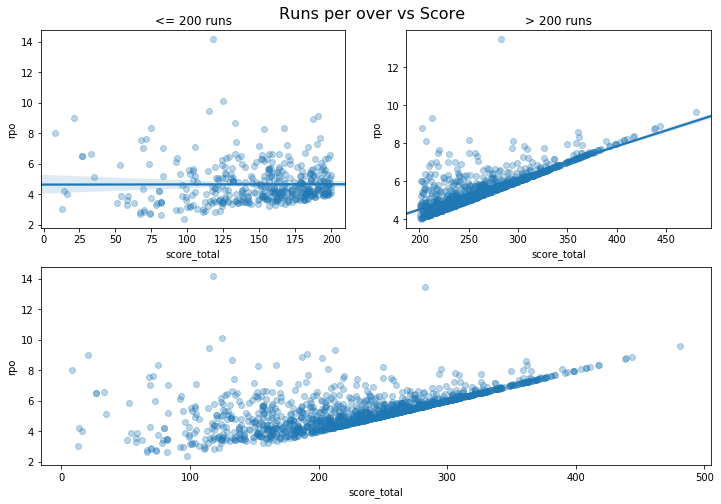

In [87]:
fig, ax = plt.subplots(2,2,figsize=[12,8], sharey=True)

plt.subplot(2,1,2);
sb.regplot(data=df_temp, y='rpo', x='score_total', scatter_kws={'alpha':0.3}, fit_reg=False);

plt.subplot(2,2,1);
sb.regplot(data=df_temp[df_temp.score_total <= 200], 
           y='rpo', x='score_total', scatter_kws={'alpha':0.3});
plt.title("<= 200 runs");

plt.subplot(2,2,2);
sb.regplot(data=df_temp[df_temp.score_total > 200],
           y='rpo', x='score_total', scatter_kws={'alpha':0.3});
plt.title("> 200 runs");

fig.text(0.4,0.9,"Runs per over vs Score", fontsize=16);

This chart shows some fairly interesting trends. Scores lower than 200 seem to have a very weak positive correlation with rpo. This positive correlation increases in strength as the numbers of runs scored increases, giving rise to a hockey stick shape. There is a dense line of points which form a baseline with no points below that line. Scores below this line are impossible to achieve in 50 overs with that value of rpo.<br>
Lets plot the rolling pearsons coefFicient to view this effect.

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


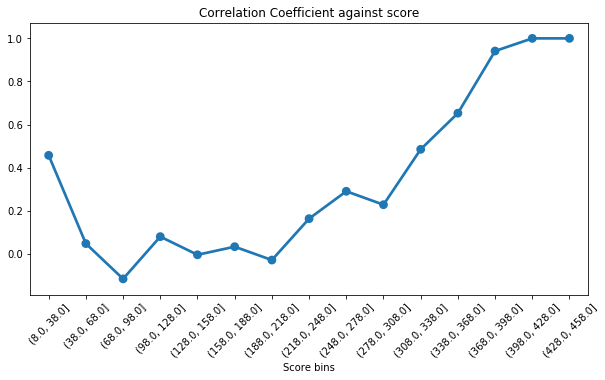

In [33]:
bins = np.arange(df_temp.score_total.min(),df_temp.score_total.max()+1,30)
df_temp['bin_score'] = pd.cut(df_temp.score_total, bins=bins)

bin_scores = df_temp.groupby('bin_score').count().index

pearson = []
for b in bin_scores:
    df = df_temp[df_temp.bin_score == b]
    pearson.append(df.score_total.corr(df.rpo))

x=np.arange(0,len(pearson),1)

plt.figure(figsize=[10,5])
sb.pointplot(x=x,y=pearson);
plt.xticks(x, bin_scores, rotation='45');
# plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.title("Correlation Coefficient against score");
plt.xlabel("Score bins");

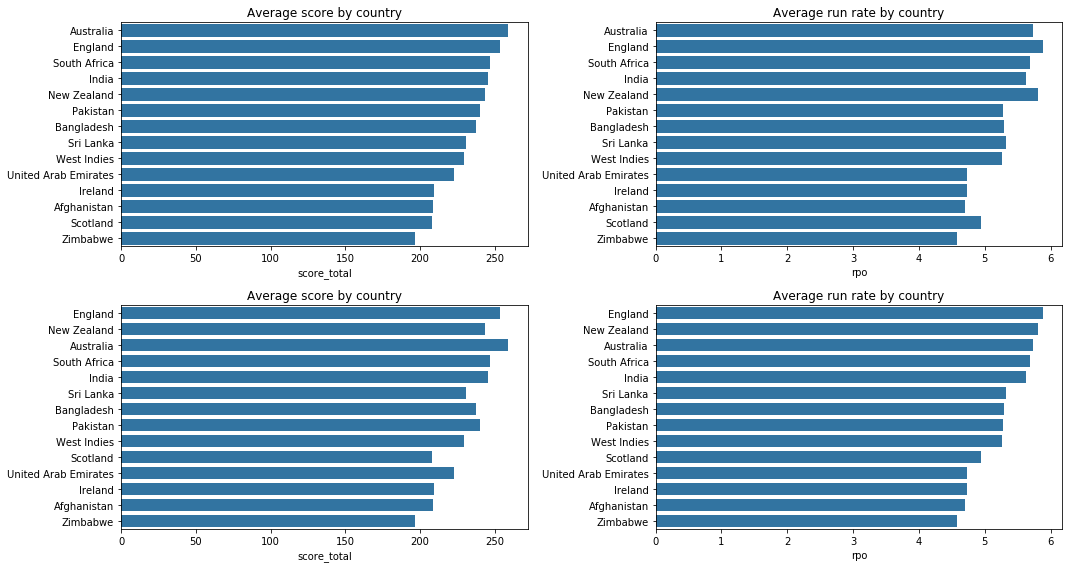

In [34]:
plt.subplots(2,2,figsize=[15,8])
order = df_temp.groupby('country').score_total.mean().sort_values(ascending=False).head(14).index

plt.subplot(2,2,1)
sb.barplot(data = df_temp, x='score_total', y='country', order=order, color=colour, ci=None);
plt.title("Average score by country");
plt.ylabel(None);

plt.subplot(2,2,2)
sb.barplot(data = df_temp, x='rpo', y='country', order=order, color=colour, ci=None);
plt.title("Average run rate by country");
plt.ylabel(None);

order = df_temp.groupby('country').rpo.mean().sort_values(ascending=False).head(14).index

plt.subplot(2,2,3)
sb.barplot(data = df_temp, x='score_total', y='country', order=order, color=colour, ci=None);
plt.title("Average score by country");
plt.ylabel(None);

plt.subplot(2,2,4)
sb.barplot(data = df_temp, x='rpo', y='country', order=order, color=colour, ci=None);
plt.title("Average run rate by country");
plt.ylabel(None);

plt.tight_layout()

Each row of bar charts shows the same data but order in terms of score and rpo. <br><br>
There is a steady decline in average scores per team, with Australia scoring on average the most runs per innings. The average run rate seems to fall into 3 main clusters with England, New Zealand, Australia, South Africa and India forming a clear top 5, another group of 5 countries forming the intermediated group then the rest of the teams. I'm most surprised by the position of the West Indies in terms of average run rate as they have the reputation of being an attacking team.

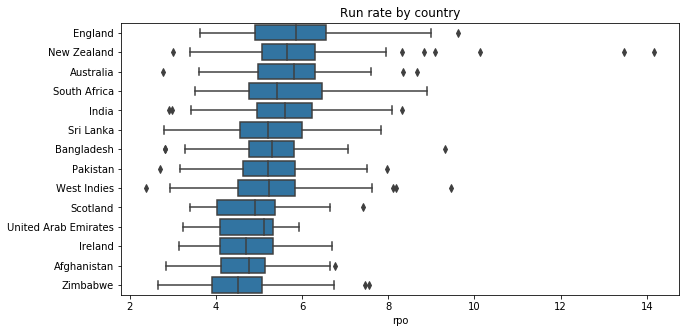

In [35]:
order = df_temp.groupby('country').rpo.mean().sort_values(ascending=False).head(14).index
plt.figure(figsize=[10,5])
sb.boxplot(data = df_temp, x='rpo', y='country', order=order, color=colour);
plt.title("Run rate by country");
plt.ylabel(None);

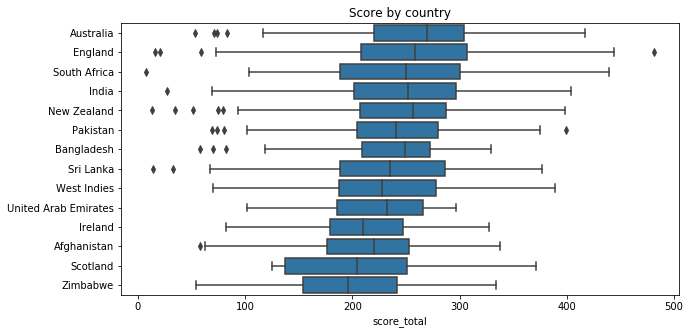

In [36]:
order = df_temp.groupby('country').score_total.mean().sort_values(ascending=False).head(14).index
plt.figure(figsize=[10,5])
sb.boxplot(data = df_temp, x='score_total', y='country', order=order, color=colour);
plt.title("Score by country");
plt.ylabel(None);

In general, all of the boxplots for for total score and runs per over are centrally distributed with minimal skew. There are a number of outliers in both plots, mostly situated to the right of the distribution for runs per over and to the left of the distribution for total score.

In [37]:
# bins = np.arange(0, df_temp.score_total.max()+1, 25)
# g = sb.FacetGrid(data=df_temp, col='country', col_wrap=4);
# g.map(sb.distplot, 'score_total', bins=bins);
# plt.tight_layout()

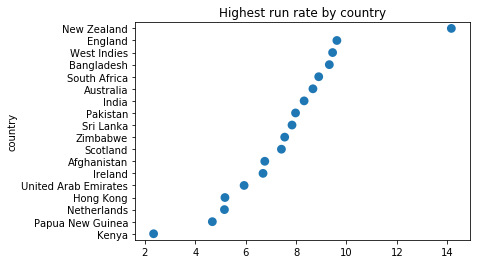

In [38]:
order = df_totals.groupby('country').rpo.max().sort_values(ascending=False).index
max_rpo = df_totals.groupby('country').rpo.max().sort_values(ascending=False).values

sb.pointplot(y=order, x=max_rpo, order=order, linestyles='');
plt.title("Highest run rate by country");

New Zealand are way out in front with two superb run rates. England are best of the rest and there is a fairly steady reduction in the maximum run rate achieved across the data set. Kenya are again in last place, having only played 1 match their average is the same as their maximum.

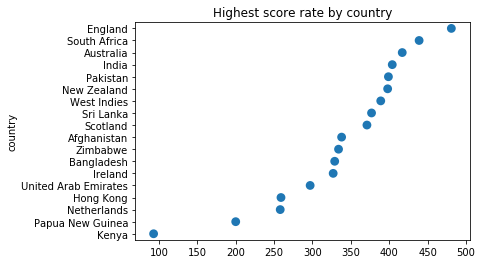

In [39]:
order = df_totals.groupby('country').score_total.max().sort_values(ascending=False).index
max_score = df_totals.groupby('country').score_total.max().sort_values(ascending=False).values

sb.pointplot(y=order, x=max_score, order=order, linestyles='');
plt.title("Highest score rate by country");

England are the world record holders for the maximum score achieved in a 50 over innings with a quite incredible 481 runs scored in trent bridge in 2018. Kenya aren't a well know cricketing nation, which is apparent in both of these charts.

#### Score information vs time

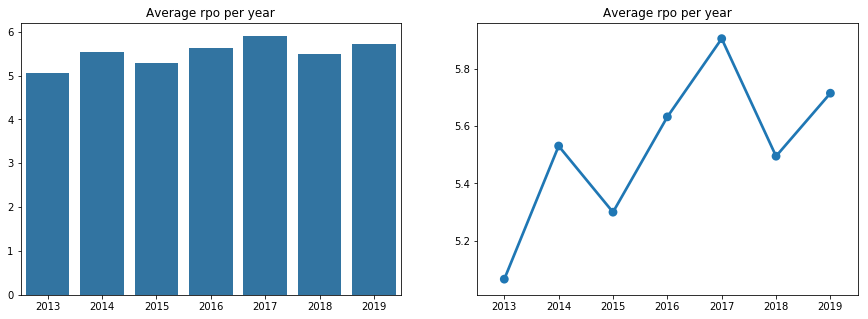

In [40]:
rpo_years = df_totals.groupby(df_match.start_date.dt.year).mean()['rpo']
ticks = [int(i) for i in rpo_years.index]

plt.subplots(1,2,figsize=[15,5])
plt.subplot(1,2,1)
sb.barplot(x=ticks, y=rpo_years.values, color=colour);
plt.title("Average rpo per year");

plt.subplot(1,2,2)
sb.pointplot(x=ticks, y=rpo_years.values, color=colour);
plt.title("Average rpo per year");

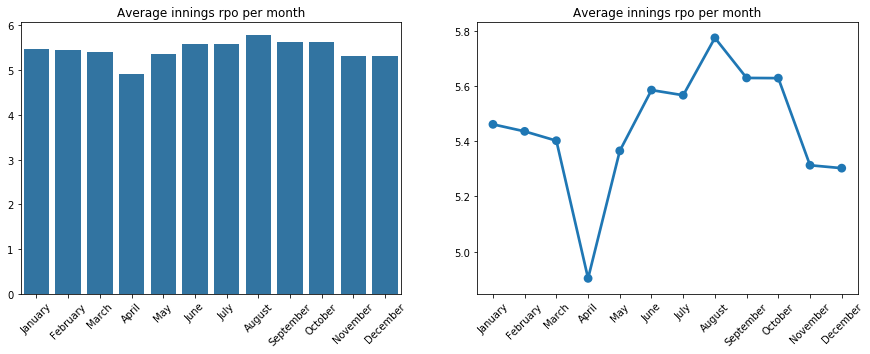

In [41]:
rpo_months = df_totals.groupby(df_match.start_date.dt.month).mean()['rpo']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']

plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sb.barplot(x=rpo_months.index.values, y=rpo_months.values, color=colour);
plt.title("Average innings rpo per month");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');


plt.subplot(1,2,2)
sb.pointplot(x=rpo_months.index.values, y=rpo_months.values, color=colour);
plt.title("Average innings rpo per month");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');

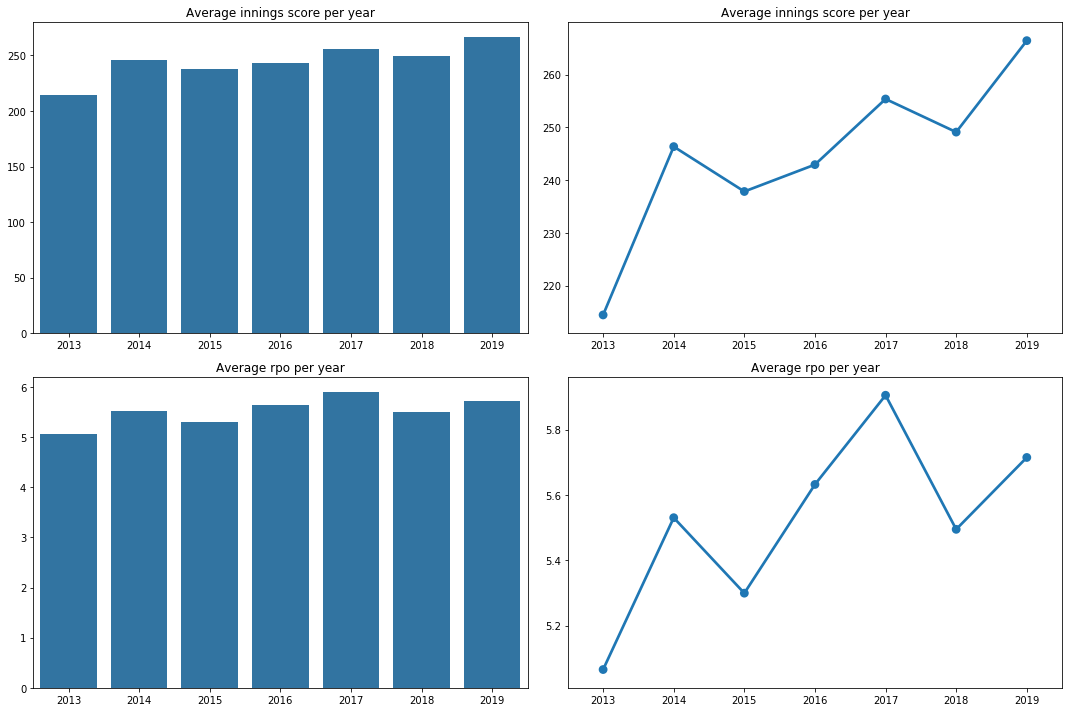

In [42]:
score_years = df_totals.groupby(df_match.start_date.dt.year).mean()['score_total']
ticks = [int(i) for i in score_years.index]

plt.subplots(2,2,figsize=[15,10])
plt.subplot(2,2,1)
sb.barplot(x=ticks, y=score_years.values, color=colour);
plt.title("Average innings score per year");

plt.subplot(2,2,2)
sb.pointplot(x=ticks, y=score_years.values, color=colour);
plt.title("Average innings score per year");

rpo_years = df_totals.groupby(df_match.start_date.dt.year).mean()['rpo']
# ticks = [int(i) for i in score_years.index]

# plt.subplots(1,2,figsize=[15,5])
plt.subplot(2,2,3)
sb.barplot(x=ticks, y=rpo_years.values, color=colour);
plt.title("Average rpo per year");

plt.subplot(2,2,4)
sb.pointplot(x=ticks, y=rpo_years.values, color=colour);
plt.title("Average rpo per year");
plt.tight_layout()

The trends in runs per over and total score each year are strongly linked. We can see that the average score per innings generally increases each year, however, its worth remember that the amount of matches played in 2019 so far is significantly less than in other years so could be more easily affected by outliers.<br><br>

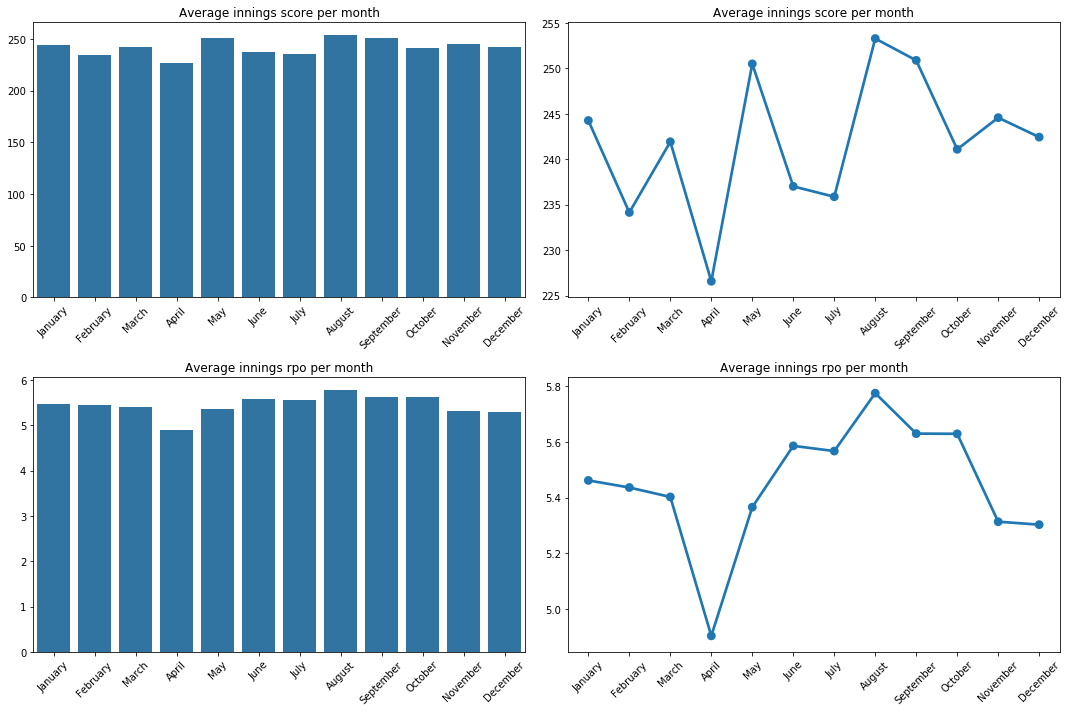

In [43]:
# score_months = df_totals.groupby(df_match.start_date.dt.month).mean()['score_total']
# sb.barplot(x=score_months.index.values, y=score_months.values, color=colour);
# plt.title("Average innings score per month");
# months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']
# plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='30');
# plt.ylim(0,270)

score_months = df_totals.groupby(df_match.start_date.dt.month).mean()['score_total']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']

plt.figure(figsize=[15,10])
plt.subplot(2,2,1)
sb.barplot(x=score_months.index.values, y=score_months.values, color=colour);
plt.title("Average innings score per month");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');


plt.subplot(2,2,2)
sb.pointplot(x=score_months.index.values, y=score_months.values, color=colour);
plt.title("Average innings score per month");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');

rpo_months = df_totals.groupby(df_match.start_date.dt.month).mean()['rpo']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']

# plt.figure(figsize=[15,10])
plt.subplot(2,2,3)
sb.barplot(x=rpo_months.index.values, y=rpo_months.values, color=colour);
plt.title("Average innings rpo per month");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');


plt.subplot(2,2,4)
sb.pointplot(x=rpo_months.index.values, y=rpo_months.values, color=colour);
plt.title("Average innings rpo per month");
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],months, rotation='45');
plt.tight_layout()

The average runs scored for each calendar month has a fairly small relative range and fluctuates quite a lot. We notcied earlier that there was a strangely low amount of matches played in April and here we can see clearly that the lowest average runs scored per month is in April. Interesting, perhaps. Lets look at the spread of matches played each month by country to see if we can gain any insight.

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


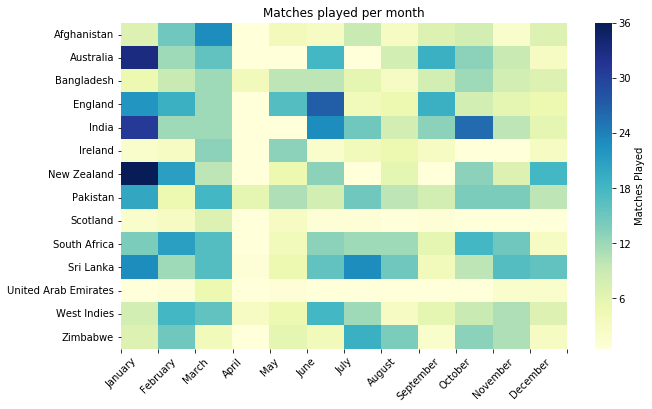

In [44]:
df_temp['month'] = df_temp.start_date.dt.month
df_temp['month'] = df_temp.month.astype('category')

grouped = df_temp.groupby(['country', 'month']).count()['match_id']
values = np.where(grouped.isnull(), 0, grouped)
values = values.reshape(14,12)

plt.figure(figsize=[10,6])
sb.heatmap(values, vmin=0.5, cmap='YlGnBu', cbar_kws={'label':'Matches Played'});

y_locs, y_labels = plt.yticks()
x_locs, x_labels = plt.xticks()

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October','November', 'December']

plt.xticks(np.arange(0,13,1), months, rotation=45);
plt.yticks(np.arange(0.5,14.5,1), grouped.index.levels[0], rotation=0, va='center');
plt.title("Matches played per month");
# plt.colorbar().set_label()


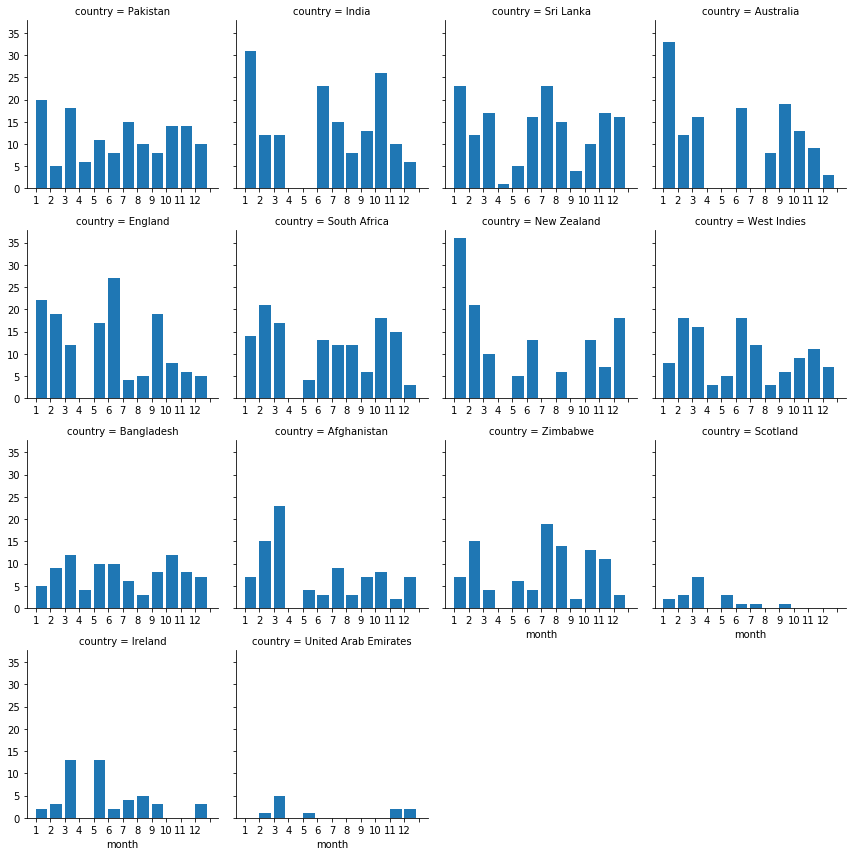

In [45]:
g= sb.FacetGrid(data=df_temp, col='country', col_wrap=4, sharex=False)

bins=np.arange(1,14,1)
labels = ['{:.0f}'.format(i) for i in bins[:-1]]

g.map(plt.hist, 'month', bins=np.arange(1,14,1), width=0.8)
g.set(xticks=bins,xticklabels=labels);

Bagladesh, Pakistan, Sri Lanka and the West Indies are the only teams who play any matches during April and they play a small number of matches. The official international cricket season in 2019 is May-September, perhaps this is the reason for so little matches being played in April.

#### Ground averages

In [46]:
df_temp = df_temp.merge(df_match.loc[:,['match_id','ground']], on='match_id')

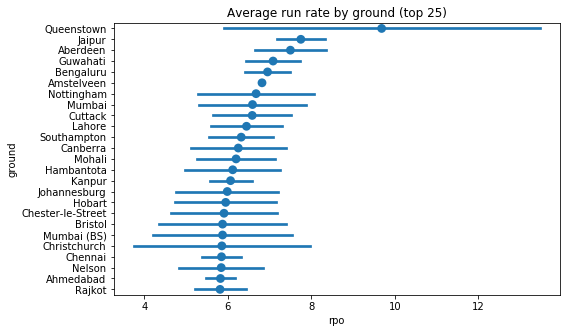

In [47]:
plt.figure(figsize=[8,5])
ground_rpo_avg = df_temp.groupby('ground').rpo.mean().sort_values(ascending=False).head(25)
sb.pointplot(data=df_temp, x='rpo', y='ground', order=ground_rpo_avg.index, ci='sd', linestyles='');
# plt.barh(width=ground_rpo_avg.values, y=ground_rpo_avg.index);
plt.title("Average run rate by ground (top 25)");


In [48]:
df_temp[df_temp.ground == "Queenstown"]

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,result,result_margin,result_method,bin_score,month,ground
208,3451,2014-01-01,West Indies,won,2nd,New Zealand,124.0,5,21.0,5.90,lost,159.0,runs,"(98.0, 128.0]",1,Queenstown
209,3451,2014-01-01,New Zealand,lost,1st,West Indies,283.0,4,21.0,13.47,won,159.0,runs,"(278.0, 308.0]",1,Queenstown


The ground with the highest average runs per over is Queenstown, however, the only match to have been played there New Zealand achieved the highest run rate across the entire dataset. This is reflected in the standard deviation which is higher than any other ground in the top 25.

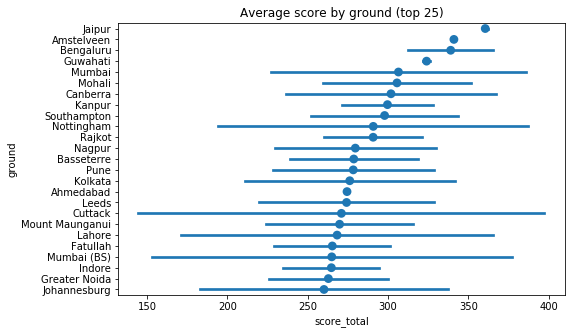

In [49]:
plt.figure(figsize=[8,5])
ground_score_avg = df_temp.groupby('ground').score_total.mean().sort_values(ascending=False).head(25)
sb.pointplot(data=df_temp, x='score_total', y='ground', order=ground_score_avg.index, ci='sd', linestyles='');
# plt.barh(width=ground_rpo_avg.values, y=ground_rpo_avg.index);
plt.title("Average score by ground (top 25)");

There is generally a much greater spread of data associated with the ground score averages than there is with the runs per over averages. It is possibale to achieve the same runs per over rate and finish with quite different scores due to some innings being shortened due to a team being bowled out before 50 overs are reach, a team catching the other teams score before 50 overs and sometimes matches are shortened due to bad weather. 

#### Score vs Result
Lets look at the relationship between total score and the match result and see if there is a threshold.

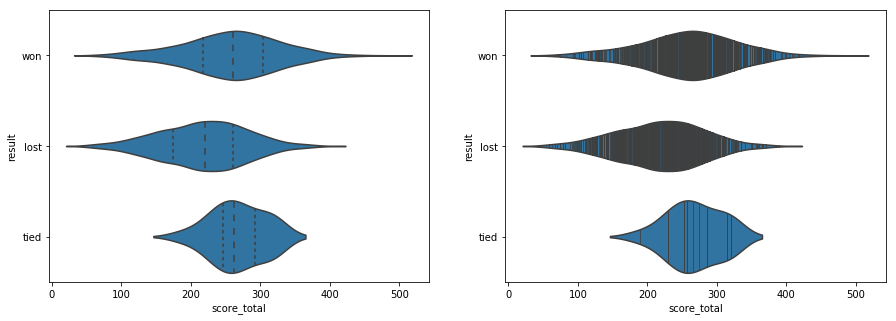

In [50]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sb.violinplot(data=df_totals, y="result", x='score_total', color=colour, inner='quartile', order =['won','lost','tied']);
plt.subplot(1,2,2)
sb.violinplot(data=df_totals, y="result", x='score_total', color=colour, inner='stick', order =['won','lost','tied']);

The distribution of scores that ended in a win are most widely spread but also most normally distributed. Losing scores have a left skew. Scores that results in a tie have the least amount of spread. There are far fewer examples of a tied result as seen in the violin-stick plot which might explain the tighter spread.

#### Score vs Batting Order and Coin Toss
Lets look at the relationship between total score and the batting order to see if there is any benefit of batting 1st or 2nd.

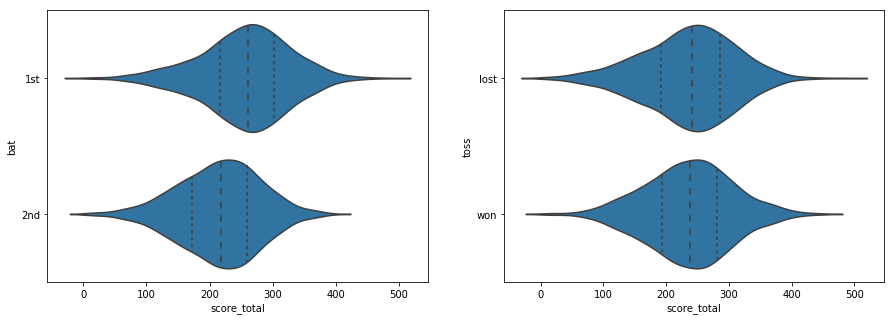

In [51]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sb.violinplot(data=df_totals, y="bat", x='score_total', color=colour, inner='quartile', order=['1st','2nd']);
plt.subplot(1,2,2)
sb.violinplot(data=df_totals, y="toss", x='score_total', color=colour, inner='quartile');


- Teams batting 1st appear to generally score more runs. The distributions have very similar spread and are separated by around 50 runs.
- The coin toss appears to have very little affect on the innings score.<br>
Lets see if this score advantage when batting 1st is reflected in the number of matches won.

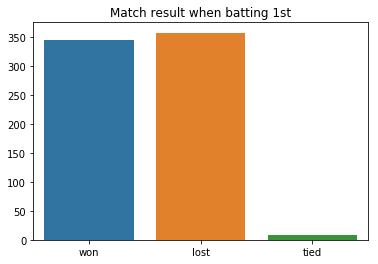

In [52]:
sb.barplot(x=['won', 'lost','tied'], y=[((df_totals.result=="won") & (df_totals.bat=="1st")).sum(), 
                                    ((df_totals.result=="lost") & (df_totals.bat=="1st")).sum(),
                                       ((df_totals.result=="tied") & (df_totals.bat=="1st")).sum()]);
plt.title("Match result when batting 1st");

Even though teams batting first score more runs on average, the number of wins does not reflect this and more matches are lost when batting first. We'll dig a little deeper into this in the next section.

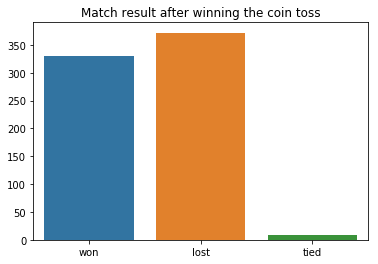

In [53]:
sb.barplot(x=['won', 'lost', 'tied'], y=[((df_totals.result=="won") & (df_totals.toss=="won")).sum(), 
                                        ((df_totals.result=="lost") & (df_totals.toss=="won")).sum(),
                                        ((df_totals.result=="tied") & (df_totals.toss=="won")).sum()]);
plt.title("Match result after winning the coin toss");

Surprisingly, more teams win the match after having lost the coin toss. In the next section we'll look into how each team performs after winning the toss, and what decisions they are most likely to make in terms of batting order.

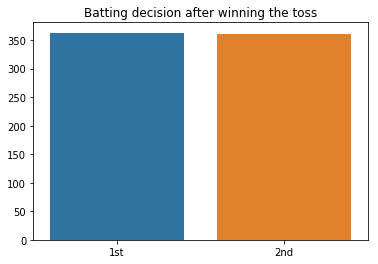

In [54]:
sb.barplot(x=['1st', '2nd'], y=[((df_totals.bat=="1st") & (df_totals.toss=="won")).sum(), 
                                        ((df_totals.bat=="2nd") & (df_totals.toss=="won")).sum()]);

plt.title("Batting decision after winning the toss");

There is very little preference for batting 1st or 2nd after having won the coin toss. We'll see in the next section if certain teams prefer to bat 1st or second after they win the toss.<br><br>
Finally, we'll look at which teams are the luckiest and unluckiest at winning the coin toss.

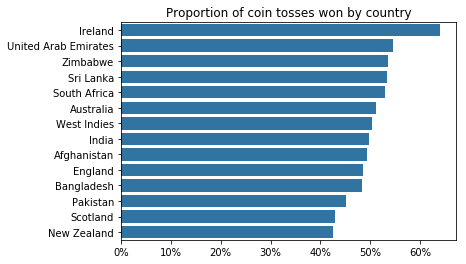

In [55]:
countries = df_temp.country.unique()
totals = [(df_temp.country==i).sum() for i in countries]
toss_won = [((df_temp.country==i)&(df_temp.toss=='won')).sum() for i in countries]
toss_prop = sorted(zip(countries, [i/j for i,j in zip(toss_won, totals)]), key=lambda x: x[1])

countries=[i[0] for i in toss_prop]
props=[i[1] for i in toss_prop]
ticks = np.arange(0,0.7,0.1)
labels= ['{:.0f}%'.format(i*100) for i in ticks]

sb.barplot(x=props, y=countries, color=colour)
plt.gca().invert_yaxis()
plt.title("Proportion of coin tosses won by country");
plt.xticks(ticks, labels);


It would appear that the luck of the irish is no myth, they win the coin toss over 60% of the time! New Zealand however are not so lucky winning just over 40% of the time.

## Multivariate
Lets now dig deeper into some of the more interesting relationships discovered in the previous section.

- Batting 1st scores higher, but batting second wins more?
    - result margins vs time, batting first and second
    - result margins vs team, batting first or second
    - team performance (score, win, result margin) batting 1st or second
    
- Team performance over time
    - win % vs year vs team
    - score vs year vs team
    - rpo vs year vs team
    - 
    
- Recommendation, win the toss and bat or bowl? 
- Analaysis of English grounds

- toss,bat,score
- team, bat, score
- score, team, year
- rpo, team, year
- result,team,toss(bat)
- result,team,bat

we'll start by crating a copy of `df_totals` so we can engineer the features without affecting the original data.


In [56]:
df_multi = df_totals.copy()
df_multi['year'] = df_multi.start_date.dt.year
df_multi = df_multi.merge(df_match.loc[:,['match_id','ground']], on='match_id')
df_multi.head()

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,result,result_margin,result_method,year,ground
0,3315,2013-01-03,Pakistan,lost,1st,India,250.0,10,48.3,5.15,won,85.0,runs,2013,Kolkata
1,3315,2013-01-03,India,won,2nd,Pakistan,165.0,10,48.0,3.43,lost,85.0,runs,2013,Kolkata
2,3316,2013-01-06,Pakistan,lost,2nd,India,157.0,10,48.5,3.21,lost,10.0,runs,2013,Delhi
3,3316,2013-01-06,India,won,1st,Pakistan,167.0,10,43.4,3.82,won,10.0,runs,2013,Delhi
4,3317,2013-01-11,Sri Lanka,lost,2nd,Australia,198.0,10,40.0,4.95,lost,107.0,runs,2013,Melbourne


In [57]:
# df_multi[(df_multi.year == 2013)&(df_multi.result_method == "runs")]

In [58]:
df_multi.bat = df_multi.bat.astype(object)

#### Effective of batting order on the score distributions

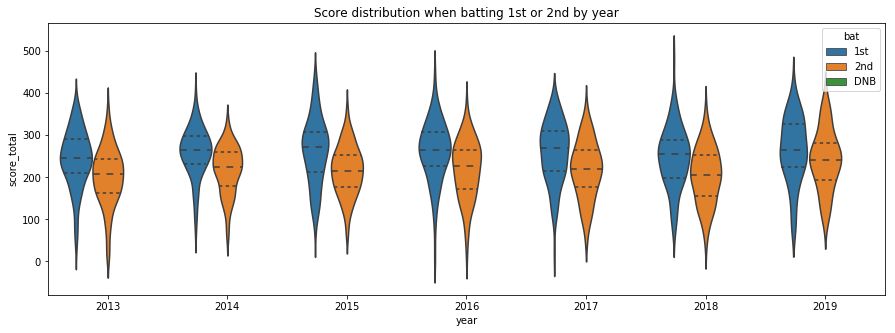

In [59]:
plt.figure(figsize=[15,5])
sb.violinplot(data=df_multi, x='year', y='score_total', hue='bat', inner='quartile');
plt.title("Score distribution when batting 1st or 2nd by year");

Here we see very similar distributions of scores across each year, with the teams batting first scoring higher than teams batting second. It is impossible for the team batting second to surpass the team batting first score by more than 6 runs because the match ends at this point.

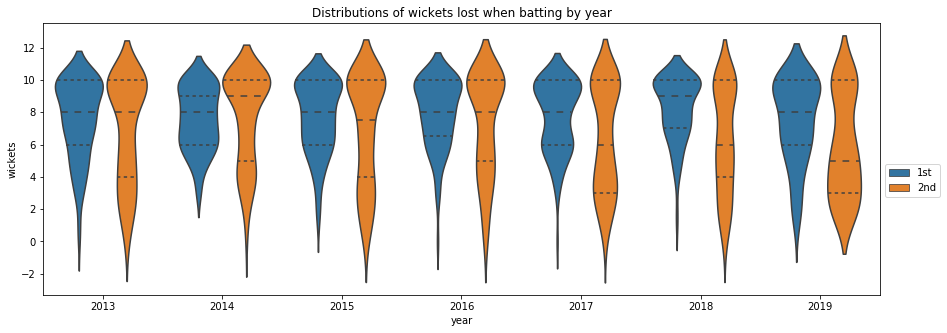

In [60]:
plt.figure(figsize=[15,5])
sb.violinplot(data=df_multi, x='year', y='wickets', hue='bat', inner='quartile', hue_order=['1st','2nd'])
plt.title("Distributions of wickets lost when batting by year");
plt.legend(bbox_to_anchor=[1,0.5]);

The distribution of wickets lost when batting first and 2nd are skewed to the left, with the distributions when batting 2nd showing more left skew than when batting 1st. 

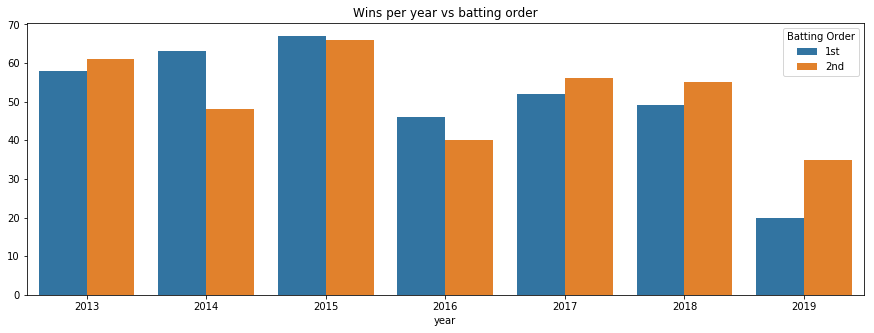

In [61]:
plt.figure(figsize=[15,5])
sb.countplot(data=df_multi[df_multi.result=="won"], x='year', hue='bat', hue_order=['1st','2nd'], dodge=True);
plt.legend(title="Batting Order");
plt.title("Wins per year vs batting order");
plt.ylabel(None);

The plot shows that there has been a switch in success of teams batting first and second. In 2014, 2015 and 2016 teams batting 1st won more matches, wheres in 2017,2018 and 2019 teams batting second have won more matches. Now lets look at how the individual teams stack up to see if we can explain the cahnge of fortune.

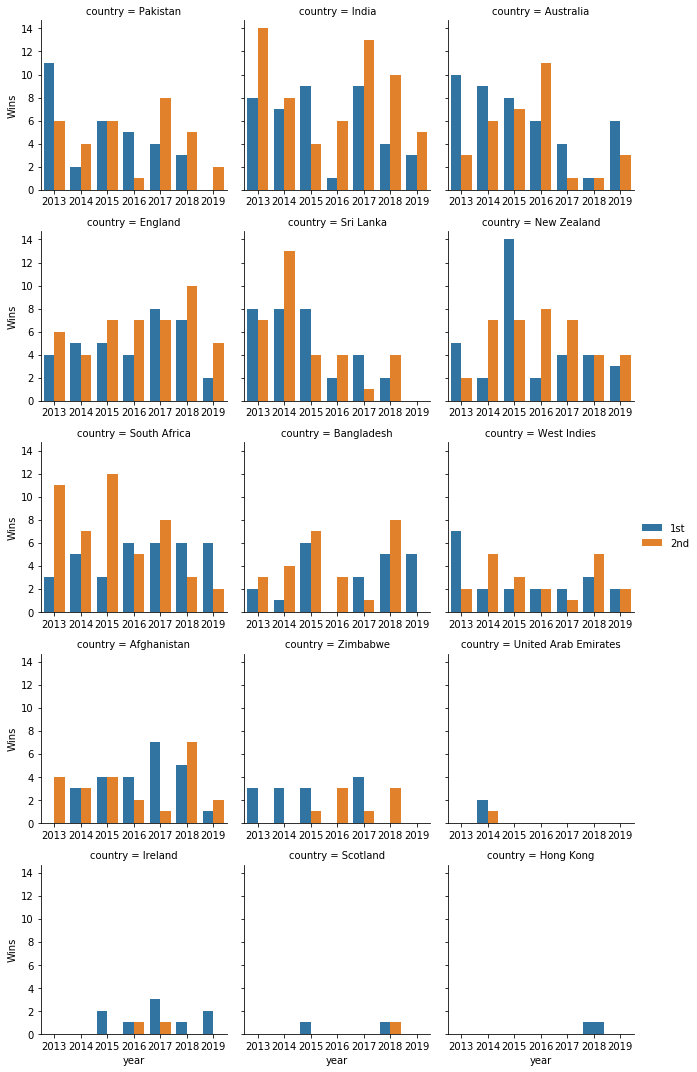

In [62]:
df_multi.year = df_multi.year.astype('category')
df_multi.country = df_multi.country.astype('object')
countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 
             'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies']

def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi[(df_multi.result=="won")], 
                 col='country', col_wrap=3, sharey=True, sharex=False)

g.map(countplot, 'year', 'bat', alpha=1, palette=sb.color_palette()[0:2])
g.add_legend();
g.set_ylabels("Wins");

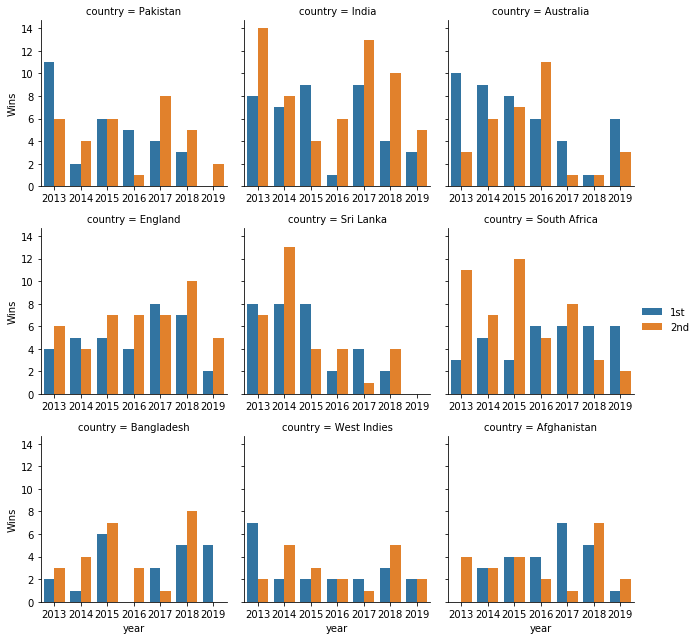

In [63]:
df_multi.year = df_multi.year.astype('category')
df_multi.country = df_multi.country.astype('object')
countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 
             'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies']

def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi[(df_multi.result=="won")&(df_multi.country.isin(countries))], 
                 col='country', col_wrap=3, sharey=True, sharex=False)

g.map(countplot, 'year', 'bat', alpha=1, palette=sb.color_palette()[0:2])
g.add_legend();
g.set_ylabels("Wins");

Here we are only considering the 9 countries taking part in this years world cup as they have played the majority of matches: 
- England, India and Pakistan all had more success when batting 2nd in the past 3 years.
- Austrlia have generally always had more success when batting 1st.
- South Africa have had the largest switch, having significantly more success batting second in 2013, 2014 and 2015. Whilst they have won double the amount of matches batting first than second in 2018 and 2019

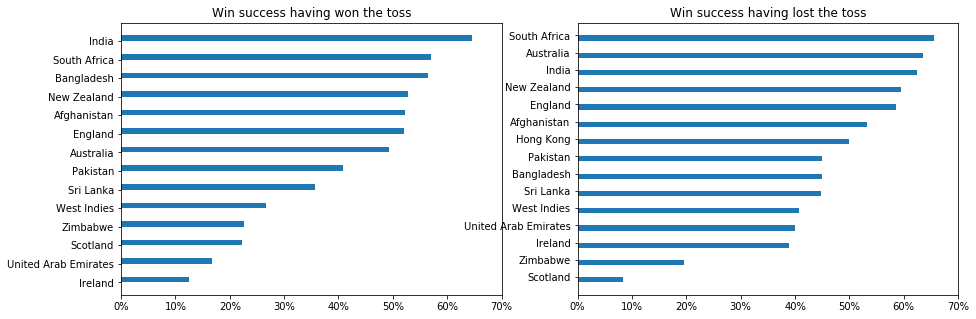

In [138]:
toss_won = df_multi.query('toss == "won"').groupby('country').count()['match_id']
win_counts = df_multi.query('toss == "won" and result=="won"').groupby('country').count()['toss']
win_prop = (win_counts / toss_won).sort_values()

toss_lost = df_multi.query('toss == "lost"').groupby('country').count()['match_id']
win_counts = df_multi.query('toss == "lost" and result=="won"').groupby('country').count()['toss']
lose_prop = (win_counts / toss_lost).sort_values()

ticks = np.arange(0, win_prop.max()+0.1, 0.1)
tick_names = ['{:0.0f}%'.format(i*100) for i in ticks]

plt.figure(figsize=[15,5])
plt.subplot(1,2,1);
plt.barh(width=win_prop.values, y=win_prop.index, height=0.3, align='edge');
plt.title("Win success having won the toss");
plt.xticks(ticks, tick_names);

plt.subplot(1,2,2);
plt.barh(width=lose_prop.values, y=lose_prop.index, height=-0.3, align='edge');
plt.title("Win success having lost the toss");
plt.xticks(ticks, tick_names);

# plt.legend(df_multi.toss, title='Toss', bbox_to_anchor=[1,0.6]);

# Turn this to explanatory pointplot

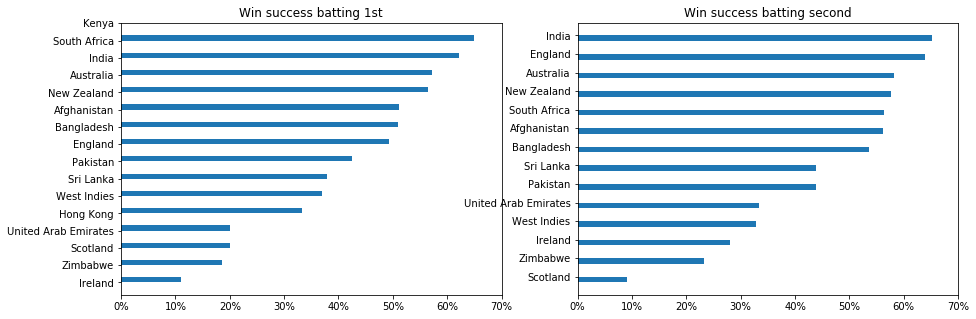

In [139]:
bat_1st = df_multi.query('bat == "1st"').groupby('country').count()['match_id']
win_counts = df_multi.query('bat == "1st" and result=="won"').groupby('country').count()['bat']
win_prop = (win_counts / bat_1st).sort_values()

bat_2nd = df_multi.query('bat == "2nd"').groupby('country').count()['match_id']
win_counts = df_multi.query('bat == "2nd" and result=="won"').groupby('country').count()['bat']
lose_prop = (win_counts / bat_2nd).sort_values()

ticks = np.arange(0, win_prop.max()+0.1, 0.1)
tick_names = ['{:0.0f}%'.format(i*100) for i in ticks]

plt.figure(figsize=[15,5])
plt.subplot(1,2,1);
plt.barh(width=win_prop.values, y=win_prop.index, height=0.3, align='edge');
plt.title("Win success batting 1st");
plt.xticks(ticks, tick_names);

plt.subplot(1,2,2);
plt.barh(width=lose_prop.values, y=lose_prop.index, height=-0.3, align='edge');
plt.title("Win success batting second");
plt.xticks(ticks, tick_names);

# plt.legend(df_multi.bat, title='bat', bbox_to_anchor=[1,0.6]);

#### Score, rpo, team

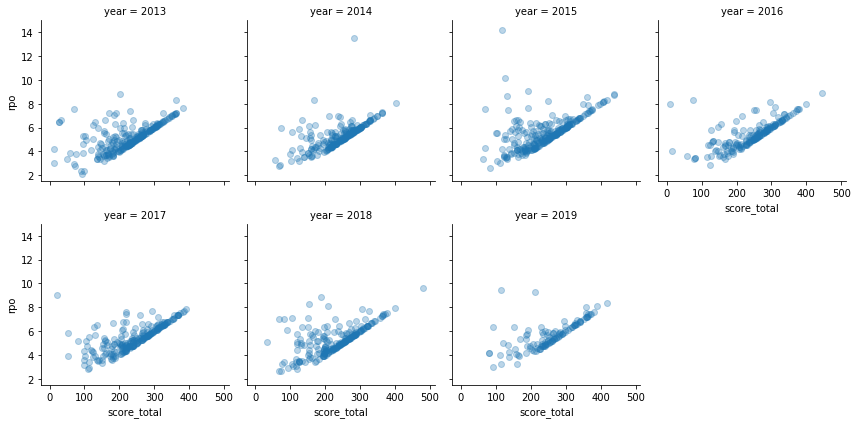

In [64]:
g = sb.FacetGrid(data=df_multi, col='year', col_wrap=4);
g.map(sb.regplot, 'score_total', 'rpo', fit_reg=False, scatter_kws={'alpha':0.3});

The relationship between score and rpo remain consistent for each year and are consistent with the hockey stick shape that we saw in the collective plot in the bivariate section. 2015 has the widest spread of points where less than 200 runs are score. We saw earlier that the most matches were played in 2015 which is the year that the previous ODI cricket world cup was held.

- Batting 1st scores higher, but batting second wins more?
    - result margins vs time, batting first and second
    - result margins vs team, batting first or second
    - team performance (score, win, result margin) batting 1st or second
    
- Team performance over time
    - win % vs year vs team
    - score vs year vs team
    - rpo vs year vs team
    - 
    
- Recommendation, win the toss and bat or bowl? 
- Analaysis of English grounds

- toss,bat,score
- team, bat, score
- score, team, year
- rpo, team, year
- result,team,toss(bat)
- result,team,bat


#### Distribution of result margins per year

/home/ding/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


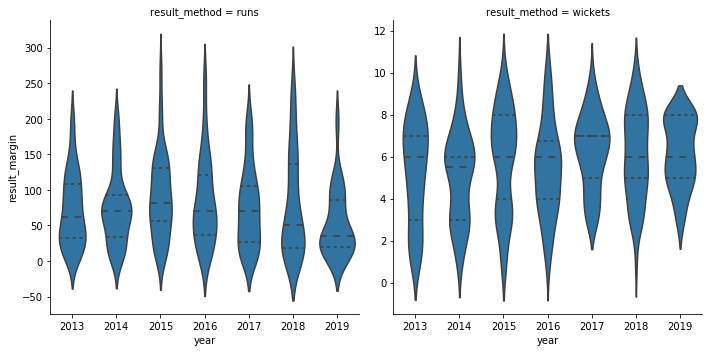

In [65]:
g = sb.FacetGrid(data=df_multi, col='result_method', sharey=False, height=5)
g.map(sb.violinplot, 'year', 'result_margin', inner='quartile');

# g = sb.FacetGrid(data=df_multi, col='result_method', sharey=False, height=5)
# g.map(sb.violinplot, 'year', 'result_margin', inner='quartile')

There has been very little change to the distribution of result margins over the years.

In [66]:
# g = sb.FacetGrid(data=df_multi, row='result_method', col='bat', col_order=['1st','2nd'], sharey=False)
# g.map(sb.violinplot, 'year', 'result_margin', inner='quartile')

# g = sb.FacetGrid(data=df_multi, row='result_method', col='result', col_order=['won','lost'], sharey=False)
# g.map(sb.violinplot, 'year', 'result_margin', inner='quartile')

# g = sb.FacetGrid(data=df_multi, row='result_method', col='toss', sharey=False)
# g.map(sb.violinplot, 'year', 'result_margin', inner='quartile')


# g1 = sb.FacetGrid(data=df_multi, col='result_method', row='year')


In [67]:
english_grounds = ['The Oval', 'Birmingham', 'Cardiff', 'Nottingham', 'Southampton', 'Leeds', "Lord's", 'Manchester', 'Chester-le-Street', 'Bristol', 'East London']

#### Team toss success

Firstly lets see who are the luckiest and unluckiest teams when it comes to the coin toss.

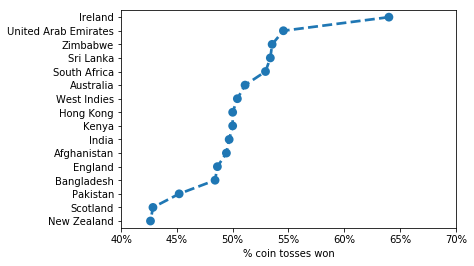

In [208]:
df_multi['toss_dum'] = np.where(df_multi.toss=="won", 1, 0)
order = df_multi.groupby('country').toss_dum.mean().sort_values(ascending=False).drop(['Netherlands','Papua New Guinea']).index

sb.pointplot(data=df_multi, y='country', x='toss_dum', order=order, linestyles="--", ci=None)
ticks, labels = plt.xticks()
plt.xticks(ticks, ['{:.0f}%'.format(i*100) for i in ticks]);
plt.xlabel("% coin tosses won");
plt.ylabel("");

Its not called the luck of the Irish for no reason, they sit atop the table of most successful coin toss winners, winning nearly 65% of the time. New Zealand and Scotland are the unluckiest nation, winning less than 45% of the coint tosses. The Netherlands and Papua New Guinea were not included having participated in only 1 match each.

In [209]:
# Get win % after winning toss 
# countries = df_multi[df_multi.toss=="won"].country.unique()
# tosses_won = [df_multi[(df_multi.country==c)&(df_multi.toss=='won')].shape[0] for c in countries]
# win_toss_win = [df_multi[(df_multi.country==c)&(df_multi.toss=='won')&(df_multi.result=='won')].shape[0] 
#                   for c in countries]

# # print(tosses_won, win_toss_win, countries, "\n")
# # print([i/j for i,j in zip(win_toss_win, tosses_won)], "\n")

# win_win_props = zip(countries, [i/j for i,j in zip(win_toss_win, tosses_won)])
# win_win_props = sorted(win_win_props, key=lambda x: x[1], reverse=True)

# # Get win % after losing toss 
# countries = df_multi[df_multi.toss=="lost"].country.unique()
# tosses_lost = [df_multi[(df_multi.country==c)&(df_multi.toss=='lost')].shape[0] for c in countries]
# lose_toss_win = [df_multi[(df_multi.country==c)&(df_multi.toss=='lost')&(df_multi.result=='won')].shape[0] 
#                   for c in countries]

# # print(tosses_lost, lose_toss_win, countries)
# # print([i/j for i,j in zip(lose_toss_win, tosses_lost)])

# lose_win_props = zip(countries, [i/j for i,j in zip(lose_toss_win, tosses_lost)])
# lose_win_props = sorted(lose_win_props, key=lambda x: x[1], reverse=True)
# lose_win_props, win_win_props

# Get win % after winning toss 
# tosses_won = df_multi.query('toss == "won"').groupby('country').count()['match_id']
# win_toss_win = df_multi.query('toss == "won" and result=="won"').groupby('country').count()['bat']
# win_win_prop = (win_toss_win / tosses_won).sort_values().dropna()

# # Get win % after losing toss 
# tosses_lost = df_multi.query('toss == "lost"').groupby('country').count()['match_id']
# lose_win_counts = df_multi.query('toss == "lost" and result=="won"').groupby('country').count()['bat']
# lose_win_prop = (lose_win_counts / tosses_lost).sort_values()[win_win_prop.index]

# plt.figure(figsize=[10,5])
# plt.barh(y=win_win_prop.index, width=win_win_prop.values, color=colour, height=0.3, align='edge')
# plt.barh(y=win_win_prop.index, width=lose_win_prop.values, color=sb.color_palette()[1], height=-0.3, align='edge')
# plt.legend(title="Coin Toss", labels=['won','lost'])

# ticks = np.arange(0,0.7,0.1)
# lables = ['{:.0f}%'.format(i*100) for i in ticks]

# plt.xticks(ticks, labels);
# plt.title("Win % given coin toss result");


In [187]:
from matplotlib.lines import Line2D
custom = [Line2D([0],[0],marker='^', color=colour),Line2D([0],[0],marker='o', color=sb.color_palette()[1])]

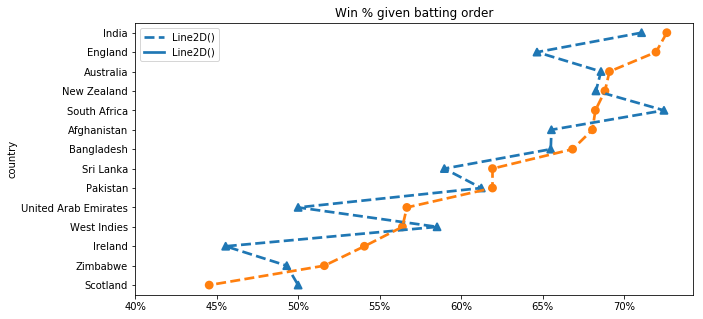

In [268]:
# Get win % after winning toss 
# countries = df_multi[df_multi.toss=="won"].country.unique()
# tosses_won = [df_multi[(df_multi.country==c)&(df_multi.toss=='won')].shape[0] for c in countries]
# win_toss_win = [df_multi[(df_multi.country==c)&(df_multi.toss=='won')&(df_multi.result=='won')].shape[0] 
#                   for c in countries]

# # print(tosses_won, win_toss_win, countries, "\n")
# # print([i/j for i,j in zip(win_toss_win, tosses_won)], "\n")

# win_win_props = zip(countries, [i/j for i,j in zip(win_toss_win, tosses_won)])
# win_win_props = sorted(win_win_props, key=lambda x: x[1], reverse=True)

# # Get win % after losing toss 
# countries = df_multi[df_multi.toss=="lost"].country.unique()
# tosses_lost = [df_multi[(df_multi.country==c)&(df_multi.toss=='lost')].shape[0] for c in countries]
# lose_toss_win = [df_multi[(df_multi.country==c)&(df_multi.toss=='lost')&(df_multi.result=='won')].shape[0] 
#                   for c in countries]

# # print(tosses_lost, lose_toss_win, countries)
# # print([i/j for i,j in zip(lose_toss_win, tosses_lost)])

# lose_win_props = zip(countries, [i/j for i,j in zip(lose_toss_win, tosses_lost)])
# lose_win_props = sorted(lose_win_props, key=lambda x: x[1], reverse=True)
# lose_win_props, win_win_props

# Get win % after losing toss 
bat2 = df_multi.query('bat == "2nd"').groupby('country').count()['match_id']
bat2_win = df_multi.query('bat == "2nd" and result=="won"').groupby('country').count()['bat']
bat2_win_prop = (bat2_win / bat2).sort_values(ascending=False).dropna()

# Get win % after winning toss 
bat1 = df_multi.query('bat == "1st"').groupby('country').count()['match_id']
bat1_win = df_multi.query('bat == "1st" and result=="won"').groupby('country').count()['bat']
bat1_win_prop = (bat1_win / bat1).sort_values()[bat2_win_prop.index]

plt.figure(figsize=[10,5])
s1 = sb.pointplot(y=bat1_win_prop.index, x=bat1_win_prop.values, color=colour, markers="^", linestyles="--")
s2 = sb.pointplot(y=bat1_win_prop.index, x=bat2_win_prop.values, color=sb.color_palette()[1], linestyles="--")

# plt.barh(y=win_win_prop.index, width=lose_win_prop.values, color=sb.color_palette()[1], height=-0.3, align='edge')
plt.legend(custom)
# plt.legend(("^","o"),labels=['won','lost'], title="Coin Toss")


ticks = np.arange(0,0.7,0.1)
lables = ['{:.0f}%'.format(i*100) for i in ticks]

plt.xticks(ticks, labels);
plt.title("Win % given batting order");


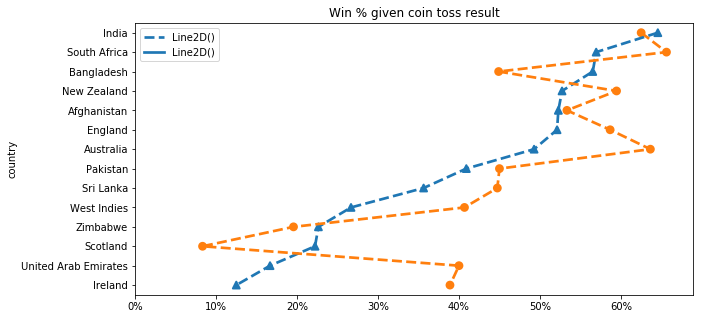

In [188]:
# Get win % after winning toss 
# countries = df_multi[df_multi.toss=="won"].country.unique()
# tosses_won = [df_multi[(df_multi.country==c)&(df_multi.toss=='won')].shape[0] for c in countries]
# win_toss_win = [df_multi[(df_multi.country==c)&(df_multi.toss=='won')&(df_multi.result=='won')].shape[0] 
#                   for c in countries]

# # print(tosses_won, win_toss_win, countries, "\n")
# # print([i/j for i,j in zip(win_toss_win, tosses_won)], "\n")

# win_win_props = zip(countries, [i/j for i,j in zip(win_toss_win, tosses_won)])
# win_win_props = sorted(win_win_props, key=lambda x: x[1], reverse=True)

# # Get win % after losing toss 
# countries = df_multi[df_multi.toss=="lost"].country.unique()
# tosses_lost = [df_multi[(df_multi.country==c)&(df_multi.toss=='lost')].shape[0] for c in countries]
# lose_toss_win = [df_multi[(df_multi.country==c)&(df_multi.toss=='lost')&(df_multi.result=='won')].shape[0] 
#                   for c in countries]

# # print(tosses_lost, lose_toss_win, countries)
# # print([i/j for i,j in zip(lose_toss_win, tosses_lost)])

# lose_win_props = zip(countries, [i/j for i,j in zip(lose_toss_win, tosses_lost)])
# lose_win_props = sorted(lose_win_props, key=lambda x: x[1], reverse=True)
# lose_win_props, win_win_props

# Get win % after winning toss 
tosses_won = df_multi.query('toss == "won"').groupby('country').count()['match_id']
win_toss_win = df_multi.query('toss == "won" and result=="won"').groupby('country').count()['bat']
win_win_prop = (win_toss_win / tosses_won).sort_values(ascending=False).dropna()

# Get win % after losing toss 
tosses_lost = df_multi.query('toss == "lost"').groupby('country').count()['match_id']
lose_win_counts = df_multi.query('toss == "lost" and result=="won"').groupby('country').count()['bat']
lose_win_prop = (lose_win_counts / tosses_lost).sort_values()[win_win_prop.index]

plt.figure(figsize=[10,5])
s1 = sb.pointplot(y=win_win_prop.index, x=win_win_prop.values, color=colour, markers="^", linestyles="--")
s2 = sb.pointplot(y=win_win_prop.index, x=lose_win_prop.values, color=sb.color_palette()[1], linestyles="--")

# plt.barh(y=win_win_prop.index, width=lose_win_prop.values, color=sb.color_palette()[1], height=-0.3, align='edge')
plt.legend(custom)
# plt.legend(("^","o"),labels=['won','lost'], title="Coin Toss")


ticks = np.arange(0,0.7,0.1)
lables = ['{:.0f}%'.format(i*100) for i in ticks]

plt.xticks(ticks, labels);
plt.title("Win % given coin toss result");


This chart indicates that most teams have a higher win percentage when they have lost the coin toss. Ireland have the lowest win percentage after winning the toss, if they could turn their skill in the coin toss into results they'd be a force to be reckoned with! India are the best team at turning toss success into a win, and South Africa are the best at winning a match after losing the toss.

India are the most successful team after winning the toss and Ireland are the least successful, not so lucky after all it would seem..

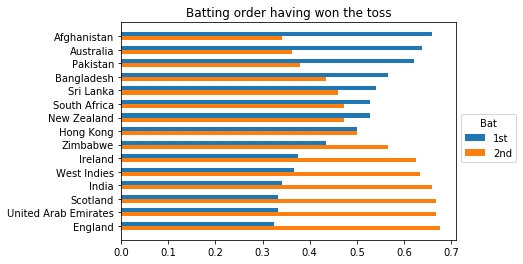

In [234]:
total_counts = df_totals.query('toss == "won"').groupby('country').count()['match_id']
bat1_counts = df_totals.query('toss == "won" and bat=="1st"').groupby('country').count()['toss']
bat1_prop = (bat1_counts / total_counts).sort_values().head(15)
bat2_prop = 1- bat1_prop

plt.barh(width=bat1_prop.values, y=bat1_prop.index, height=0.3, align='edge');
plt.barh(width=bat2_prop.values, y=bat2_prop.index, height=-0.3, align='edge');
plt.title("Batting order having won the toss");
plt.legend(['1st','2nd'], title='Bat', bbox_to_anchor=[1,0.6]);

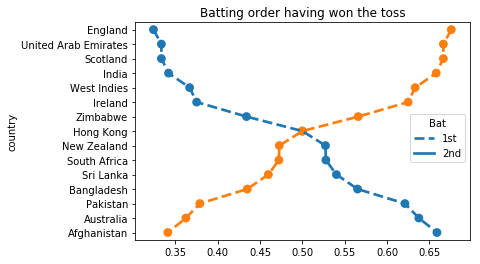

In [242]:
total_counts = df_totals.query('toss == "won"').groupby('country').count()['match_id']
bat1_counts = df_totals.query('toss == "won" and bat=="1st"').groupby('country').count()['toss']
bat1_prop = (bat1_counts / total_counts).sort_values(ascending=True).head(15)
bat2_prop = 1- bat1_prop

sb.pointplot(x=bat1_prop.values, y=bat1_prop.index, linestyles='--', order=bat1_prop.index);
sb.pointplot(x=bat2_prop.values, y=bat2_prop.index, linestyles='--', order=bat1_prop.index, color=sb.color_palette()[1]);
plt.title("Batting order having won the toss");
plt.legend(['1st','2nd'], title='Bat', bbox_to_anchor=[1,0.6]);

We can see that Afghanistan, Australia, Pakistan and Sri Lanka all significantly favour batting first having won the toss, whilst England, India, Ireland, West Indies and Zimbabwe favour bowling first having won the toss. India is the suprising one here, given that the pitches in India are normally very difficult to bat on in the 4th innings and the ball is spinning a great deal, but perhaps they enjoy that, whatever the reason it seems to work for them.

## Success After Winning the Toss

In [231]:
# total_counts = df_totals.query('toss == "won"').groupby('country').count()['match_id']
# win_counts = df_totals.query('toss == "won" and result=="won"').groupby('country').count()['toss']
# win_prop = (win_counts / total_counts).sort_values()
# # lose_prop = 1- win_prop

# ticks = np.arange(0, win_prop.max()+0.1, 0.1)
# tick_names = ['{:0.0f}%'.format(i*100) for i in ticks]


# plt.barh(width=win_prop.values, y=win_prop.index, height=0.8, align='center');
# plt.title("Win success having won the toss");
# plt.xticks(ticks, tick_names);

In [232]:
# toss_won = df_totals.query('toss == "won"').groupby('country').count()['match_id']
# win_counts = df_totals.query('toss == "won" and result=="won"').groupby('country').count()['toss']
# win_prop = (win_counts / toss_won).sort_values()

# toss_lost = df_totals.query('toss == "lost"').groupby('country').count()['match_id']
# win_counts = df_totals.query('toss == "lost" and result=="won"').groupby('country').count()['toss']
# lose_prop = (win_counts / toss_lost)[win_prop.index]

# ticks = np.arange(0, win_prop.max()+0.1, 0.1)
# tick_names = ['{:0.0f}%'.format(i*100) for i in ticks]

# plt.barh(width=win_prop.values, y=win_prop.index, height=0.3, align='edge');
# plt.barh(width=lose_prop.values, y=lose_prop.index, height=-0.3, align='edge');

# plt.title("Win success given toss result");
# plt.xticks(ticks, tick_names);
# plt.legend(df_totals.toss, title='Toss', bbox_to_anchor=[1,0.6]);

#### Analysis of country score and RPO per year

Starting with average score per year for each team.

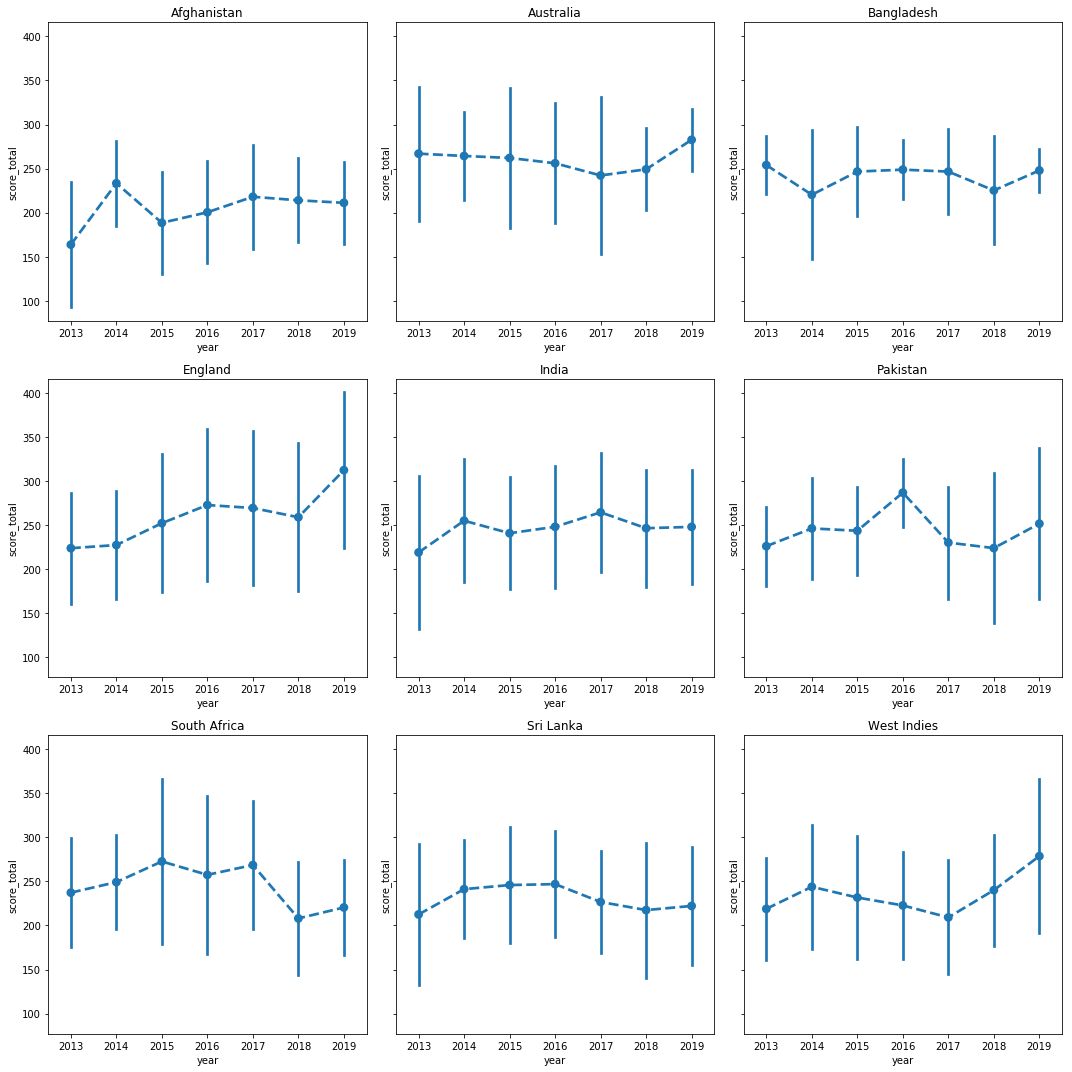

In [217]:
countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 
             'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies']

fig, axs = plt.subplots(3,3,figsize=[15,15], sharey=True)
axs = axs.flatten()

for i, c, ax in zip(np.arange(1,10,1), countries, axs):
    plt.sca(ax)
    data = df_multi[(df_multi.country==c)]
    sb.pointplot(data=data, x='year', y='score_total', ci='sd', linestyles='--', color=sb.color_palette()[0])
    plt.title(c)
    
fig.tight_layout()

Team average scores are fairly widely spread and generally oscilate around a constant mean. England have shown the most consistet increase in scoring average since 2013, while South Africas scoring average has worsened by the most. <br><br>
We worked out previously the total score for each team might not be the best metric for measuring the teams batting performance because a team batting second will never surpass their opponents score. Below we look at the relationship between runs per over for teams when batting 1st or second, the match results and coin toss result.

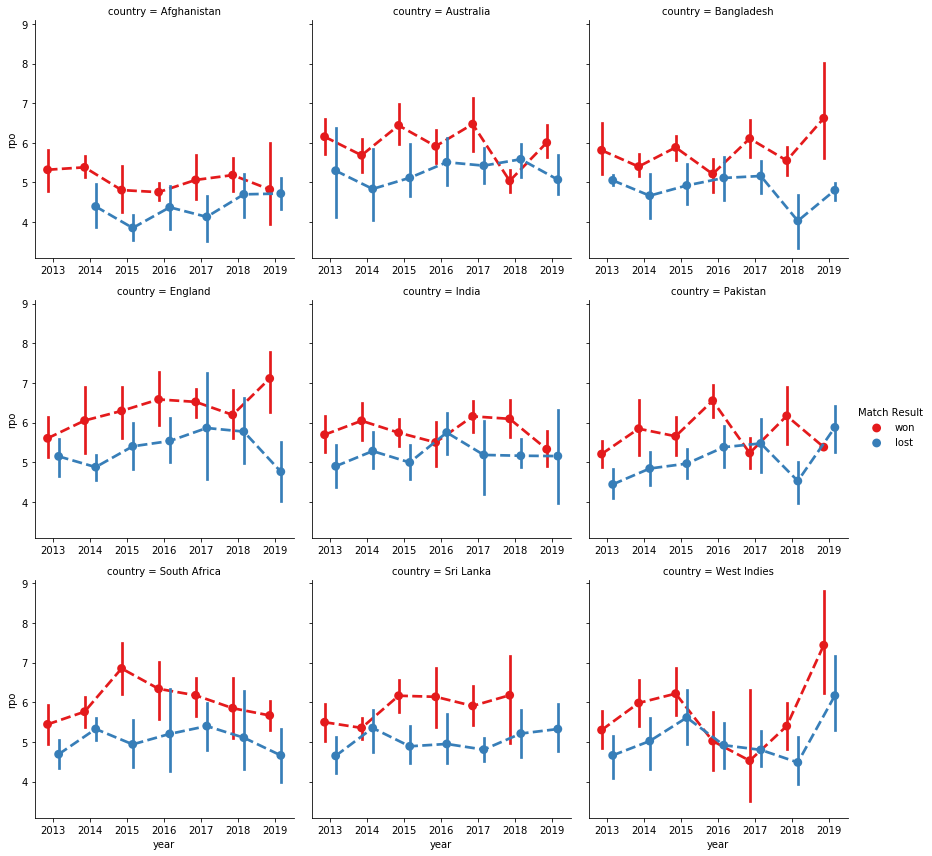

In [220]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi, col='country', col_order=countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'result', hue_order=['won','lost'], dodge=0.3, palette="Set1", linestyles='--', ci=95)
g.add_legend(title="Match Result")

As one would anticipate, the average team score is higher when a team wins almost all of the time with some exceptions. Notably, Australias average score in 2018 for games in which they won was lower than in games in which they had lost. Sometimes cricket is a curious sport.

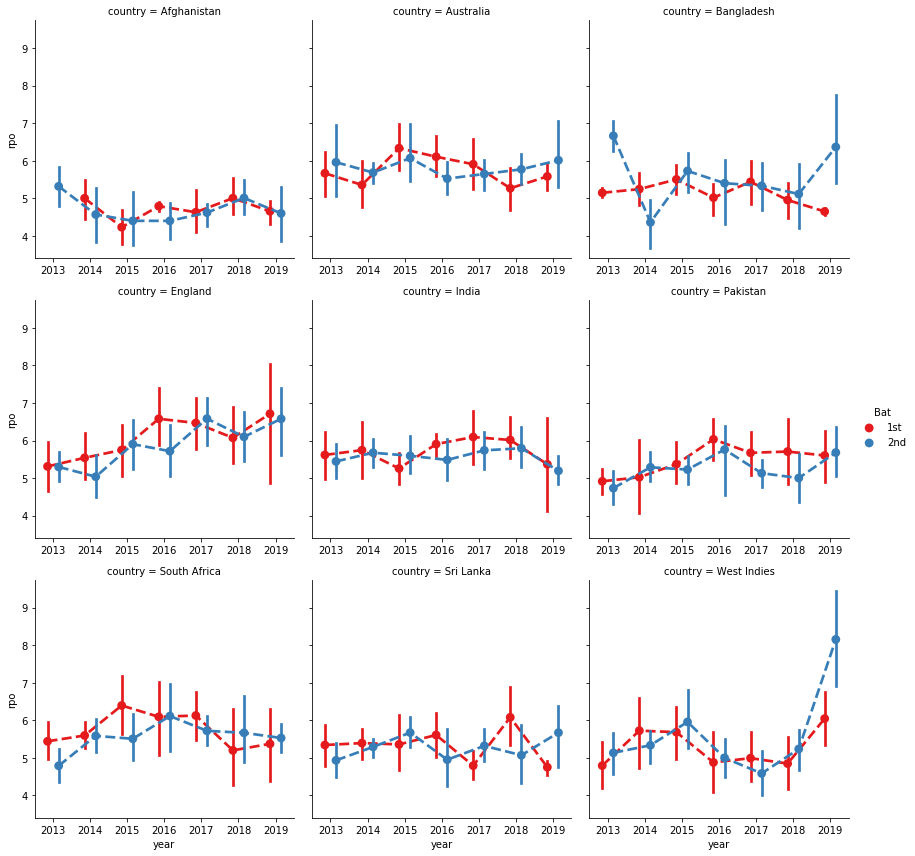

In [221]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi, col='country', col_order=countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'bat', hue_order=['1st','2nd'], dodge=0.3, palette="Set1", linestyles='--', ci=95)
g.add_legend(title="Bat")

In general there is very little difference in rpo when a team is batting first or second. The West Indies have had a big jump in their average run rate batting secon in 2019, possibly due to not playing many matches yet.

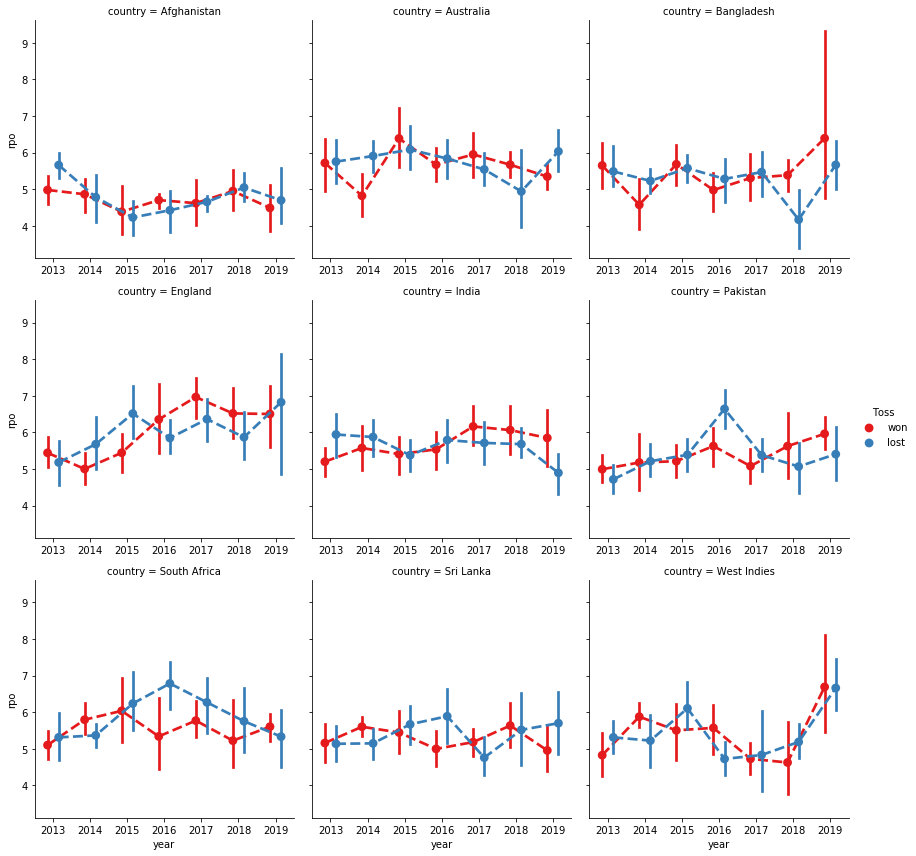

In [222]:
def pointplot(x,y,hue,**kwargs):
    sb.pointplot(x=x,y=y, hue=hue, **kwargs)

g = sb.FacetGrid(data=df_multi, col='country', col_order=countries, col_wrap=3, height=4, sharex=False)
g.map(pointplot, 'year', 'rpo', 'toss', hue_order=['won','lost'], dodge=0.3, palette="Set1", linestyles='--', ci=95)
g.add_legend(title="Toss")

In [225]:
# All Countries

# countries = df_temp.groupby('country').mean().index

# fig, axs = plt.subplots(6,3,figsize=[15,15], sharey=True, sharex=True)
# axs = axs.flatten()

# for i, c in enumerate(countries):
#     plt.sca(axs[i]);
#     data = df_multi.query('country == @c')
#     sb.pointplot(data=data, x='year', y='score_total', ci='sd', linestyles='-')
#     plt.title(c)
    
# fig.tight_layout()

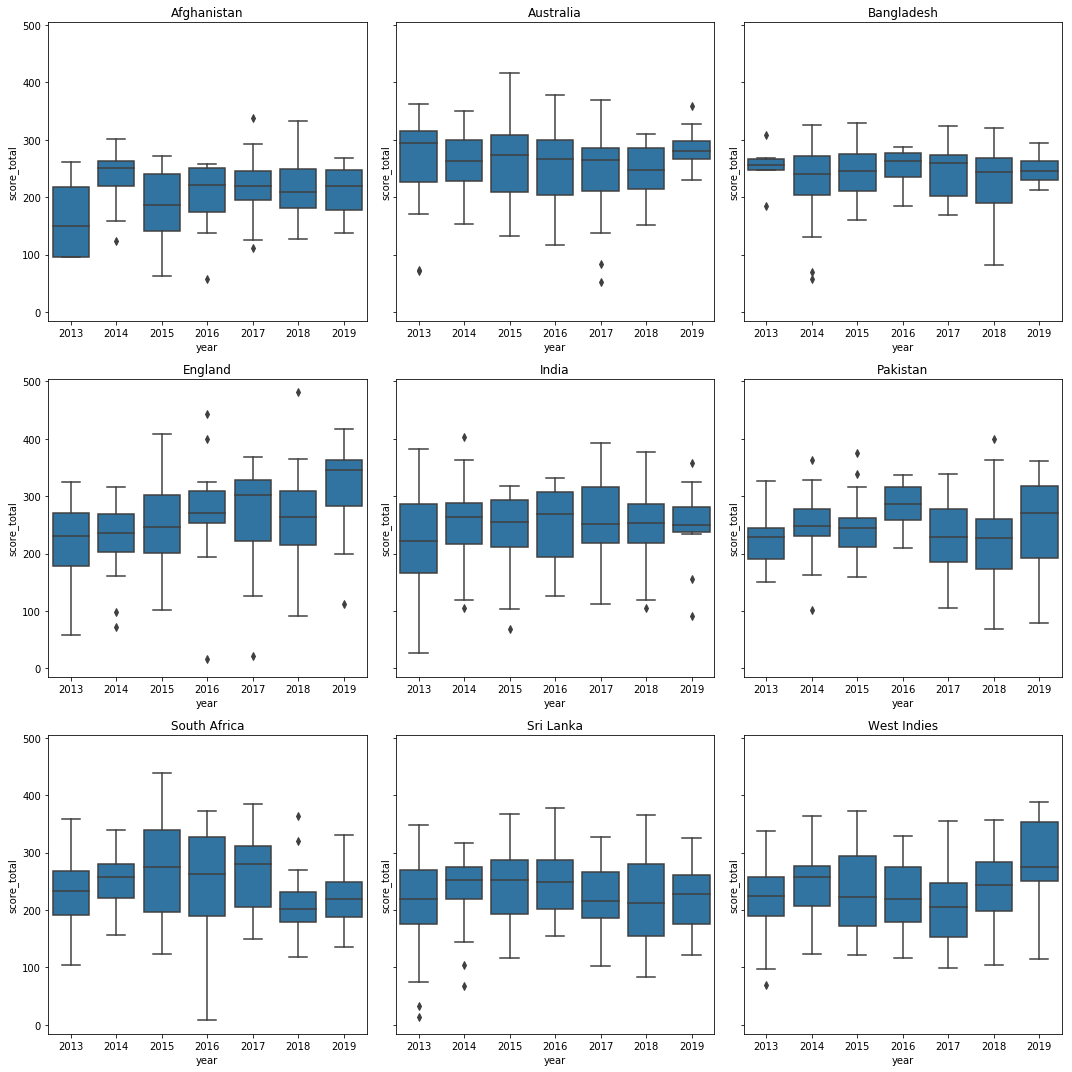

In [228]:
countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 
             'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies']

fig, axs = plt.subplots(3,3,figsize=[15,15], sharey=True, sharex=False)
axs = axs.flatten()

for i, c in enumerate(countries):
    plt.sca(axs[i]);
    data = df_multi.query('country == @c')
    sb.boxplot(data=data, x='year', y='score_total', color=colour)
    plt.title(c)
    
fig.tight_layout()

# df_multi.query('country == "England"').groupby('year').mean()

In [128]:
df_totals.groupby('opposition').mean()['wickets'].sort_values()

opposition
Kenya           2.500000
Netherlands     3.000000
P.N.G.          4.000000
Hong Kong       5.500000
U.A.E.          5.727273
Zimbabwe        6.030303
Scotland        6.238095
West Indies     6.436975
Ireland         6.580000
Sri Lanka       6.742331
Pakistan        7.102740
Bangladesh      7.157895
England         7.417808
Australia       7.711111
New Zealand     7.875969
Afghanistan     7.921348
India           8.138365
South Africa    8.213235
Name: wickets, dtype: float64

In [129]:
df_totals.query('result_method == "wickets"').groupby('opposition').mean()

,match_id,score_total,wickets,overs,rpo,result_margin
opposition,,,,,,
Afghanistan,3749.409091,201.863636,6.727273,43.768182,4.581136,5.340909
Australia,3715.066667,244.450000,6.866667,44.585000,5.417500,5.116667
Bangladesh,3789.065217,234.108696,5.956522,44.334783,5.319783,6.195652
England,3719.594595,243.067568,6.824324,43.525676,5.632432,5.581081
Hong Kong,3762.000000,169.000000,3.000000,33.000000,5.060000,7.000000
India,3723.197531,230.765432,7.938272,45.697531,5.015432,6.358025
Ireland,3843.541667,221.375000,5.708333,42.458333,5.281250,5.416667
Kenya,3417.500000,95.500000,2.500000,18.500000,4.960000,7.500000
Netherlands,NaN,NaN,NaN,NaN,NaN,NaN


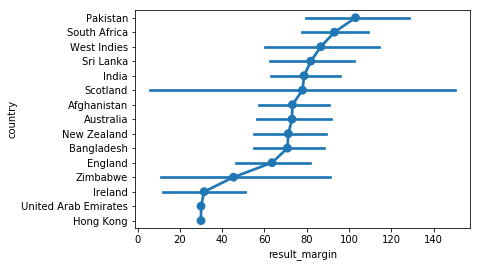

In [251]:
win_runs = df_totals.query('result_method == "runs" and result == "won"').groupby('country').mean()['result_margin'].sort_values(ascending=False).dropna()
# pakistan win by most runs
data=df_multi[(df_multi.result_method=="runs")&(df_multi.result=="won")]
sb.pointplot(data=data ,y='country', x='result_margin', order=win_runs.index, ci=95);

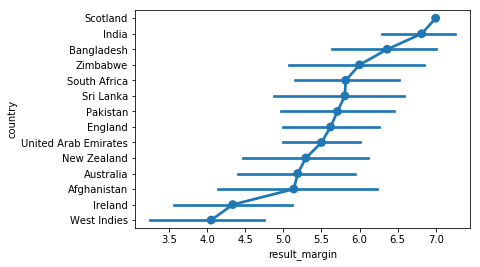

In [255]:
win_wicks = df_totals.query('result_method == "wickets" and result == "won"').groupby('country').mean()['result_margin'].sort_values(ascending=False).dropna()
data=df_multi[(df_multi.result_method=="wickets")&(df_multi.result=="won")]
sb.pointplot(data=data ,y='country', x='result_margin', order=win_wicks.index, ci=95);

In [132]:
df_totals.query('result_method == "wickets" and result == "lost"').groupby('country').mean()['result_margin'].sort_values()

country
Australia               5.035714
India                   5.047619
Scotland                5.285714
Pakistan                5.352941
United Arab Emirates    5.500000
England                 5.531250
New Zealand             5.538462
Afghanistan             5.545455
South Africa            5.666667
Sri Lanka               5.744681
Papua New Guinea        6.000000
Bangladesh              6.041667
Ireland                 6.066667
West Indies             6.093750
Zimbabwe                6.558824
Hong Kong               7.000000
Kenya                   7.500000
Netherlands                  NaN
Name: result_margin, dtype: float64

In [133]:
df_run = df_totals.query('result_method == "runs" and result == "won"')
df_wick = df_totals.query('result_method == "wickets" and result == "won"')

/home/ding/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


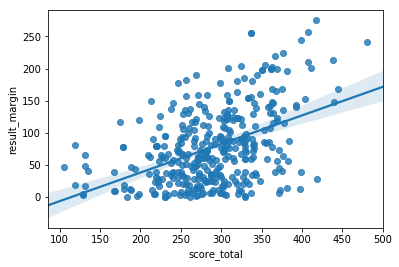

In [134]:
sb.regplot(data=df_run, x='score_total', y='result_margin');

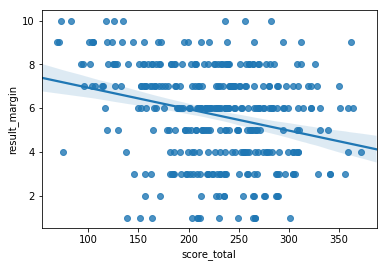

In [259]:
sb.regplot(data=df_wick, x='score_total', y='result_margin', y_jitter=0);

In [260]:
ground_avgs = df_run.groupby('ground').mean()['score_total']
df_run['score_vs_avg'] = np.NaN

for ground, avg in zip(ground_avgs.index, ground_avgs.values):
    df_run['score_vs_avg'] = np.where(df_run.ground == ground, df_run.score_total - avg, df_run.score_vs_avg)


/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


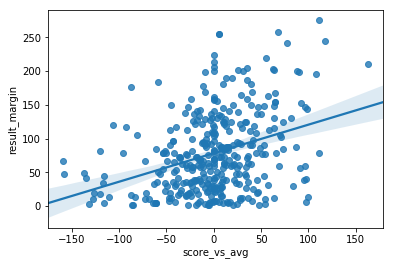

In [137]:
sb.regplot(data=df_run, x='score_vs_avg', y='result_margin');

In [276]:
bins = np.arange(-175,200,25)
# df_run['ground_avg_bins'] = pd.cut(df_run.score_vs_avg, bins=bins)
df_run = df_run[df_run.result.isin(['won','lost'])]
df_run.result= np.where(df_run.result=='won',1,0)

/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


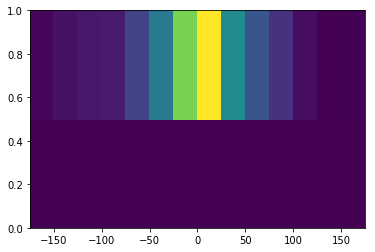

In [297]:
plt.hist2d(data=df_run, x='score_vs_avg', y='result', bins=[bins, [0,0.5,1]], vmin=0.5);

In [307]:
df = df_multi[df_multi.result.isin(['won','lost'])]
df.result= np.where(df.result=='won',1,0)

ground_avgs = df.groupby('ground').mean()['score_total']
df['score_vs_avg'] = np.NaN

for ground, avg in zip(ground_avgs.index, ground_avgs.values):
    df['score_vs_avg'] = np.where(df.ground == ground, df.score_total - avg, df.score_vs_avg)
    
# plt.hist2d(data=df, x='score_vs_avg', y='result', bins=[bins, [0,1]]);

/home/ding/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/ding/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

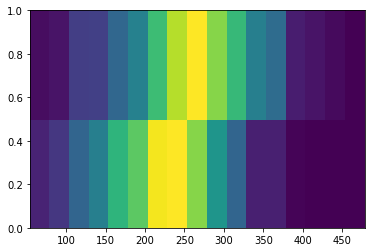

In [305]:
bins=np.arange(df.score_total.min(), df.score_total.max()+1, 25)
plt.hist2d(data=df, x='score_total', y='result', bins=(bins, (0,0.5,1)));

## Plot counts in each cell for matches won and lost

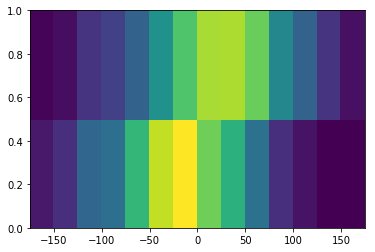

In [309]:
bins = np.arange(-175,200,25)
plt.hist2d(data=df, x='score_vs_avg', y='result', bins=[bins, [0,0.5,1]], vmin=0.5);

In [306]:
df.groupby('result').count()

,match_id,start_date,country,toss,bat,opposition,score_total,wickets,overs,rpo,result_margin,result_method,year,ground,toss_dum
result,,,,,,,,,,,,,,,
0,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716
1,716,716,716,716,716,716,716,716,716,716,716,716,716,716,716


#### Team win % based on previous result

In [312]:
df_ordered = df_totals.copy()
df_ordered.info()

def compareResult(df, col, countries):
    idx = df.index.values
    for idx
    for c in countries:
        data = df[df[col]==c]
        data['result']
        
def compareResult(x):
    
    
    
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1506 entries, 0 to 1505
Data columns (total 14 columns):
match_id         1506 non-null int64
start_date       1506 non-null datetime64[ns]
country          1506 non-null category
toss             1506 non-null object
bat              1506 non-null category
opposition       1506 non-null category
score_total      1487 non-null float64
wickets          1506 non-null int64
overs            1506 non-null float64
rpo              1487 non-null float64
result           1502 non-null category
result_margin    1432 non-null float64
result_method    1432 non-null object
ground           1506 non-null category
dtypes: category(5), datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 130.1+ KB


In [315]:
# df_ordered.start_date.sort_values()

In [357]:
countries=['England']
for c in countries:
    df = df_ordered.query('country == @c')
    df.start_date = df.start_date.sort_values()
    df.reset_index(inplace=True)
    idx = df.index.values
    streak = [(df.result[i+1]=="won")&(df.result[i]=="won") for i in idx[:-1]]
    
np.mean([int(i) for i in streak])

0.3103448275862069